# Model structuur

Een belangrijke stap in tijdreeksanalyse is het bepalen van de modelstructuur van het tijdreeksmodel. Dit is het onderwerp van dit Notebook. We beperken ons hier tot het bepalen van het deterministische deel van het model. Het bepalen van het ruismodel is onderdeel van het notebook over modelkalibratie. In dit notebook wordt een overzicht gegeven van de verschillende opties die mogelijk zijn voor de modelstructuur.

**Inhoudsopgave**

- [Basis modelstructuur](#Basis-modelstructuur)
- [Response functies](#Responsfuncties)
- [Effect van neerslag en verdamping](#Effect-van-neerslag-en-verdamping)
- [Drempel niet-lineariteit](#Drempel-niet-lineariteit)
- [Andere verklarende variabelen](#Andere-verklarende-variabelen)
- [Veranderingen in het systeem](#Veranderingen-in-het-systeem)
- [Discussie](#Discussie)

## Algemeen stappenplan
Voor het kiezen van de gewenste modelstructuur is het belangrijk om vast te stellen wat het doel van de tijdreeksmodellering is. Wanneer het doel van de modellering is vastgesteld, kunnen de volgende stappen worden doorlopen:

1. **Systeemanalyse**: bepaal mogelijke hydrologische variabelen,
2. **Modelbouw**: bepaal hoe deze variabelen worden omgezet in fluctuaties,
3. **Controle**: bepaal welke variabelen daadwerkelijk invloed hebben.

We gaan ervan uit dat de eerste stap al is uitgevoerd en bespreken de tweede stap. In dit notebook wordt een overzicht gegeven van de bouwstenen die beschikbaar zijn om een model te bouwen. De laatste stap, controle, is onderdeel van het notebook over "Modelbeoordeling". 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pastas as ps

from matplotlib.gridspec import GridSpec

ps.set_log_level("ERROR")
#ps.show_versions()
%config InlineBackend.figure_format = 'retina'

## Basis modelstructuur
Het tijdreeksmodel kan in zijn meest algemene vorm als volgt worden beschreven:

$$ h(t) = \sum_{m=0}^M h_m(t) + d + r(t) $$

waar $h(t)$ de gemeten stijghoogte is, $h_m(t)$ de bijdrage van invloed $m$, $d$ het basisniveau van het model, en $r(t)$ zijn de modelresiduën. Het totaal aantal invloeden dat bijdraagt aan de stijghoogte fluctuaties is $M$. Dit notebook gaat voornamelijk over het bepalen van deze bijdragen, maar eerst volgt een korte uitleg over het basisniveau $d$.

### Het basisniveau van het model
Vrijwel elk tijdreeksmodel bevat een constante (hier parameter $d$) waarmee het model op de juiste hoogte wordt gebracht. Hoewel verleidelijk, is het niet altijd juist een fysische betekenis aan deze constante toe te kennen. In de literatuur wordt soms verwezen naar de drainagebasis, het niveau waar het grondwater na verloop van tijd naar toe gaat wanneer alle invloeden nul zijn. Of deze interpretatie juist is hangt echter af van het model. Veiliger is daarom om naar $d$ te verwijzen als het basisniveau van het model.

Voor het bepalen van de waarde van het basisniveau zijn verschillende methoden beschikbaar. Een eerste optie is bijvoorbeeld om na een simulatie het gemiddelde van de residuën te nemen als waarde voor $d$. Dit betekent dat de parameter niet geschat hoeft te worden tijdens de kalibratie. Een andere optie is om $d$ mee te schatten als een parameter ([Collenteur et al. 2019](#Referenties)). Dit heeft als voordeel dat er ook iets gezegd kan worden over de onzekerheid van deze parameter. Het is nog onduidelijk wat het effect van deze twee methoden is op de uiteindelijke resultaten. 

Voor de voorbeelden in dit notebook maakt het wel of niet meefitten van de constante vrijwel niet uit voor de resultaten. Dit kan getest worden door de variabele `fit_constant` op `True` of `False` te zetten in de volgende code-blok (let op: code-blokken worden niet weergegeven in de PDF-versie van dit notebook). In de rest van dit notebook wordt de waarde van het basisniveau $d$ geschat tijdens kalibratie.

In [2]:
fit_constant = True

### Bijdragen
Fluctuaties in de stijghoogte kunnen door verschillende oorzaken ontstaan. Vaak hebben we een idee welke oorzaken belangrijk zijn, maar net zo vaak is het achterhalen van deze oorzaken juist het doel van de modellering. Het berekende effect van een bepaalde invloed zal in zekere mate afhangen van de gekozen vorm van de modellering. Of, in andere woorden, de manier waarop een invloed wordt vertaald in een bijdrage aan de stijghoogtefluctuaties. De keuze voor een bepaalde modelstructuur kan dus van invloed zijn op de modelresultaten.

We kunnen twee typen invloeden onderscheiden: gemeten en niet gemeten invloeden. Voor gemeten invloeden zijn verklarende tijdreeksen beschikbaar om de bijdrage van een invloed aan de stijghoogte fluctuaties te bepalen. Dit zijn bijvoorbeeld: neerslag, potentiele verdamping, ontrekkingen, oppervlakte waterstanden, en luchtdruk metingen. Dit type invloeden kan worden vertaald in een bijdrage aan de stijghoogtefluctuaties met behulp van een impuls responsfunctie.

Voor niet gemeten invloeden zijn (vaak) geen verklarende tijdreeksen beschikbaar en het effect van dit type invloeden is lastiger vast te stellen. Voorbeelden zijn veranderend landgebruik en een ingreep in de waterhuishouding (bv. het dempen van een sloot of het uitbaggeren van een kanaal). Sommige van deze bijdragen kunnen worden meegenomen door een trend mee te nemen in de modellering. De informatie die de modelleur moet opgeven is dan een tijdsperiode of tijdstip waarop een verandering heeft plaats gevonden.

## Responsfuncties
De vertaling van een verklarende tijdreeks naar een bijdrage aan de stijghoogtefluctuaties kan worden gedaan met behulp van een impuls responsfunctie [(zie ook von Asmuth et al., 2002)](#Referenties). De impuls responsfunctie beschrijft in dit geval hoe de stijghoogte reageert op een impuls in de verklarende variabele. Er zijn tal van responsfuncties die kunnen worden gekozen om een verklarende tijdreeks om te zetten in een bijdrage aan de stijghoogtefluctuaties. De keuze voor een specifieke responsfunctie kan bijvoorbeeld afhangen van het type verklarende reeks (bv. neerslag of een rivier), maar ook van het systeem (bv. een dikke of dunne overzadigde zone).

Vaak wordt een algemene responsfunctie met 4 parameters of een vereenvoudigde vorm daarvan gebruikt als impuls responsfunctie. Afhankelijk van het systeem kunnen bepaalde parameters worden vastgezet, wat het aantal te schatten parameters verlaagt. In de volgende figuur worden drie impuls responsfuncties getoond die elk een vereenvoudigde vorm van de 4-parameter functie zijn: Exponentieel, Gamma, en Hantush.

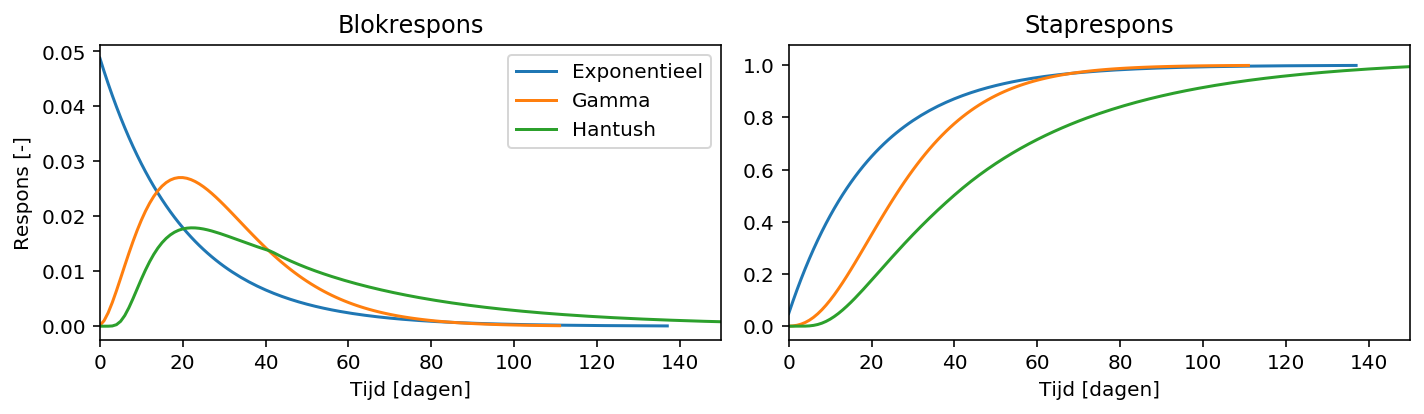

In [3]:
# Voorbeeld van Gamma responsfunctie waar n=1, en hetzelfde model met een exponentiele functie

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 3), sharex=True)

rfuncs = [ps.Exponential, ps.Gamma, ps.Hantush]
params = [[1, 20], [1, 3, 10], [6, 50, 0.7]]

for rfunc, param in zip(rfuncs, params):
    rfunc = rfunc(up=True)
    p = rfunc.get_init_parameters("p")
    ax1.plot(rfunc.block(param))
    ax2.plot(rfunc.step(param))
ax1.set_xlim(0, 150)
ax1.set_title("Blokrespons")
ax2.set_title("Staprespons")
ax1.set_xlabel("Tijd [dagen]")
ax2.set_xlabel("Tijd [dagen]")
ax1.set_ylabel("Respons [-]")
ax1.legend(["Exponentieel", "Gamma", "Hantush"]);
plt.tight_layout()

De Exponentiele respons heeft 2 parameters, en de Gamma en de Hantush respons hebben elk 3 parameters. Zoals blijkt uit de figuur hierboven helpt de extra parameter van de Gamma en de Hantush om een grotere vertraging in de response van de stijghoogte te simuleren. Het kan voorkomen dat de parameters van de Gamma responsfunctie na kalibratie eigenlijk een Exponentiele responsfunctie simuleren. Het is dan mogelijk parameters vast te zetten of de responsfunctie te veranderen en op die manier het aantal te schatten parameters te reduceren.

Hoewel de naam "Hantush" suggereert dat de parameters fysisch geinterpreteerd kunnen worden, hangt de validiteit van een dergelijke interpretatie af van de lokale bodemopbouw in relatie tot de aannames van de Hantush functie. Verder dient het aanbeveling verschillende responsfuncties te testen. Dit zal in dit notebook dan ook meermaals worden gedaan. Per software pakket dient te worden bepaalt welke responsfuncties beschikbaar zijn.

## Effect van neerslag en verdamping

Vrijwel alle grondwaterstanden in Nederland worden in meer of mindere mate beïnvloed door neerslag en verdamping. Deze twee verklarende tijdsreeksen worden daarom bijna altijd in een tijdreeksmodel opgenomen. De manier waarop deze tijdreeksen worden meegenomen in het model kunnen sterk verschillen. We kunnen grofweg vier methoden onderscheiden: 

- Neerslag en verdamping als aparte invloeden met aparte responsefuncties
- Netto neerslagoverschot ($N = P-fE$) en 1 responsfunctie 
- Niet-lineaire grondwateraanvulling en 1 responsfunctie
- Direct opgeven van de grondwateraanvulling en 1 responsfunctie 

In de volgende drie secties worden drie modellen gemaakt volgens de eerste drie methoden voor het modelleren van het effect van neerslag en verdamping. De laatste methode wordt niet getoond maar kan eenvoudig worden toegepast. Bij deze methode wordt buiten de tijdreeksmodellering om de grondwateraanvulling of neerslagoverschot berekend (bv. met een SWAP of Hydrus-1D model), waarbij deze tijdreeks dan als invoer wordt gebruikt en vertaald met een responsfunctie.

### Voorbeeld data
De stijghoogte tijdreeks die in dit voorbeeld wordt gebruikt is gemeten in peilbuis B32C0639 (filter 1) nabij de Bilt. Neerslag en potentiele Makkink verdamping zijn beschikbaar van het meteorologisch meetstation de Bilt van het Koninklijk Nederlands Meet Instituut (KNMI). De figuur hieronder laat de gemeten stijghoogte tijdreeks zien.

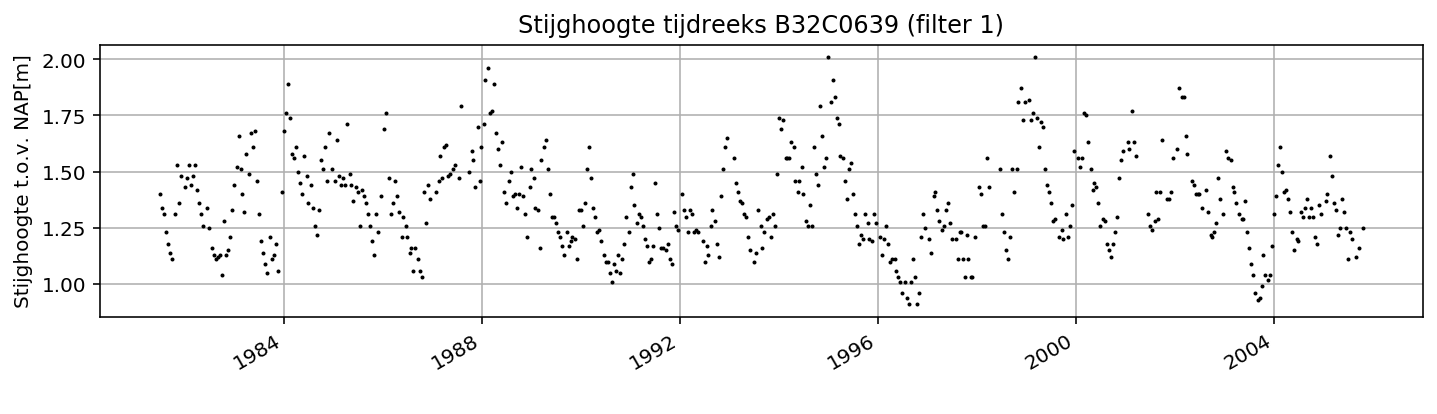

In [4]:
head = pd.read_csv("data/B32C0639001.csv",  parse_dates=['date'], index_col='date', squeeze=True)
head.name = "Stijghoogte B32C0639 (filter 1)"
fig, ax1 = plt.subplots(1, 1, figsize=(10,3))
head.plot(ax=ax1, marker=".", color="k", linestyle=" ", markersize=2)
ax1.grid()
ax1.set_title("Stijghoogte tijdreeks B32C0639 (filter 1)")
ax1.set_ylabel("Stijghoogte t.o.v. NAP[m]")
ax1.set_xlabel(" ");
plt.tight_layout()

### Neerslag en verdamping als aparte invloeden
Bij deze methode worden de twee tijdreeksen van neerslag en verdamping onafhankelijk van elkaar meegenomen in het tijdreeksmodel. Door middel van twee aparte responsfuncties worden de tijdreeksen vertaald in bijdragen aan de stijghoogtefluctuaties. Hieronder is een voorbeeld gegeven van het resultaat van een dergelijk model voor de stijghoogte tijdreeks gemeten in peilbuis B32C0639 (filter 1).

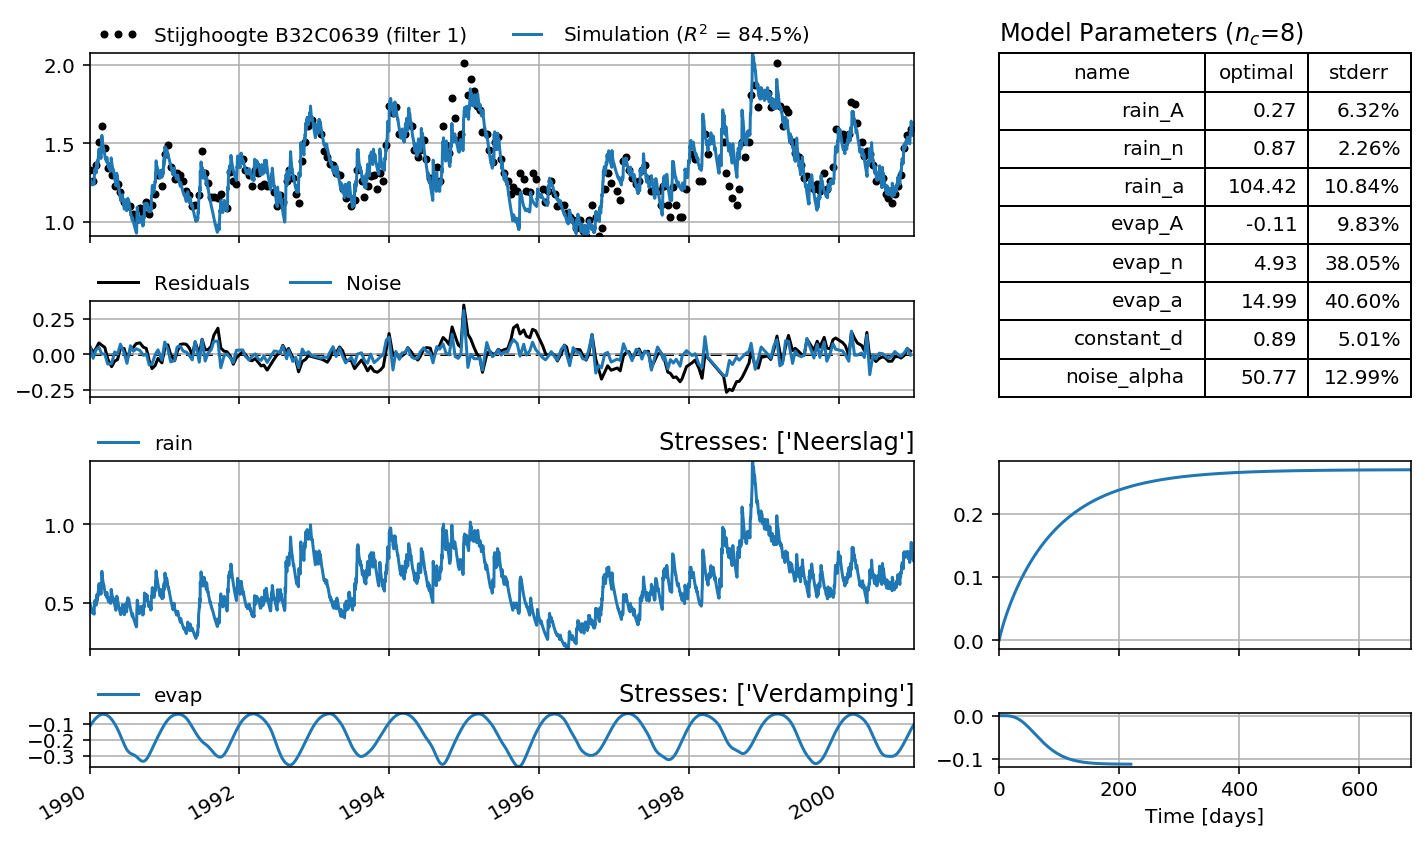

In [5]:
# Voorbeeld van neerslag en verdamping met aparte responsfuncties
evap = ps.read_knmi("data/etmgeg_260.txt", variables="EV24").series * 1e3
rain = ps.read_knmi("data/etmgeg_260.txt", variables="RH").series * 1e3
rain.name = "Neerslag"
evap.name = "Verdamping"

tmin = "1990"
tmax = "2001"

# Create the basic Pastas model
ml1 = ps.Model(head, name="2 responsen")

# Add a recharge model
rm1 = ps.StressModel(rain, rfunc=ps.Gamma, name="rain", up=True)
rm2 = ps.StressModel(evap, rfunc=ps.Gamma, name="evap", up=False)

ml1.add_stressmodel([rm1, rm2])

# Solve the model
ml1.solve(noise=True, tmin=tmin, tmax=tmax, report=False, fit_constant=fit_constant)
ml1.plots.results(figsize=(10, 6), adjust_height=True);
plt.tight_layout()

De onderste twee linker subplots tonen de geschatte invloed van de neerslag en de verdamping. De neerslag heeft een positief (stijgend) effect op de stijghoogte en de verdamping een dalend effect. Voor beide responsfuncties (zie de onderste twee rechter subplots) moeten de parameters worden geschat. Het totaal aantal geschatte parameters van dit model is 8.

Enkele kanttekeningen over de fysische interpretatie van deze modelvorm zijn van toepassing. De responsen van de stijghoogte op neerslag en verdamping verschillen in dit voorbeeld sterk van elkaar. Vanuit een grondwater perspectief is het de vraag of het logisch is dat de responsen op neerslag en verdamping zo sterk van elkaar verschillen. Aan de andere kant is de responsfunctie ook verantwoordelijk voor de vertaling van de onverzadigde zone processen, en omdat het patroon van neerslag en verdamping anders zijn verdeeld in de tijd zou het ook zo kunnen zijn dat de respons anders is.

### Lineair neerslagoverschot
Een veelgemaakte aanname is dat de respons van de stijghoogte op neerslag en verdamping vergelijkbaar is, maar in de tegenovergestelde richting. Hoewel uit bijvoorbeeld bovenstaande figuur blijkt dit niet altijd het geval is, is in de praktijk gebleken dat deze aanname toch vaak goede modellen oplevert. Onder deze aanname is het mogelijk eerst het neerslagoverschot te berekenen en deze flux te vertalen in een bijdrage aan de stijghoogtefluctuaties met een enkele responsfunctie.

Omdat vaak gewerkt wordt met de potentiele of referentie verdamping (bijvoorbeeld Makkink of Penman-Monteith) wordt een verdampingsfactor $f$ gebruikt. Het neerslag overschot $N$ wordt dan berekend als [(zie bv. Berendrecht et al. 2003)](#Referenties): 

$$N(t) = P(t) - f * E(t)$$

waar $P(t)$ de neerslag is, $E(t)$ de potentiele verdamping, en $f$ een kalibratie parameter. Een belangrijk voordeel van dit model ten op zichte van het voorgaande model is het kleinere aantal parameters dat geschat moet worden.

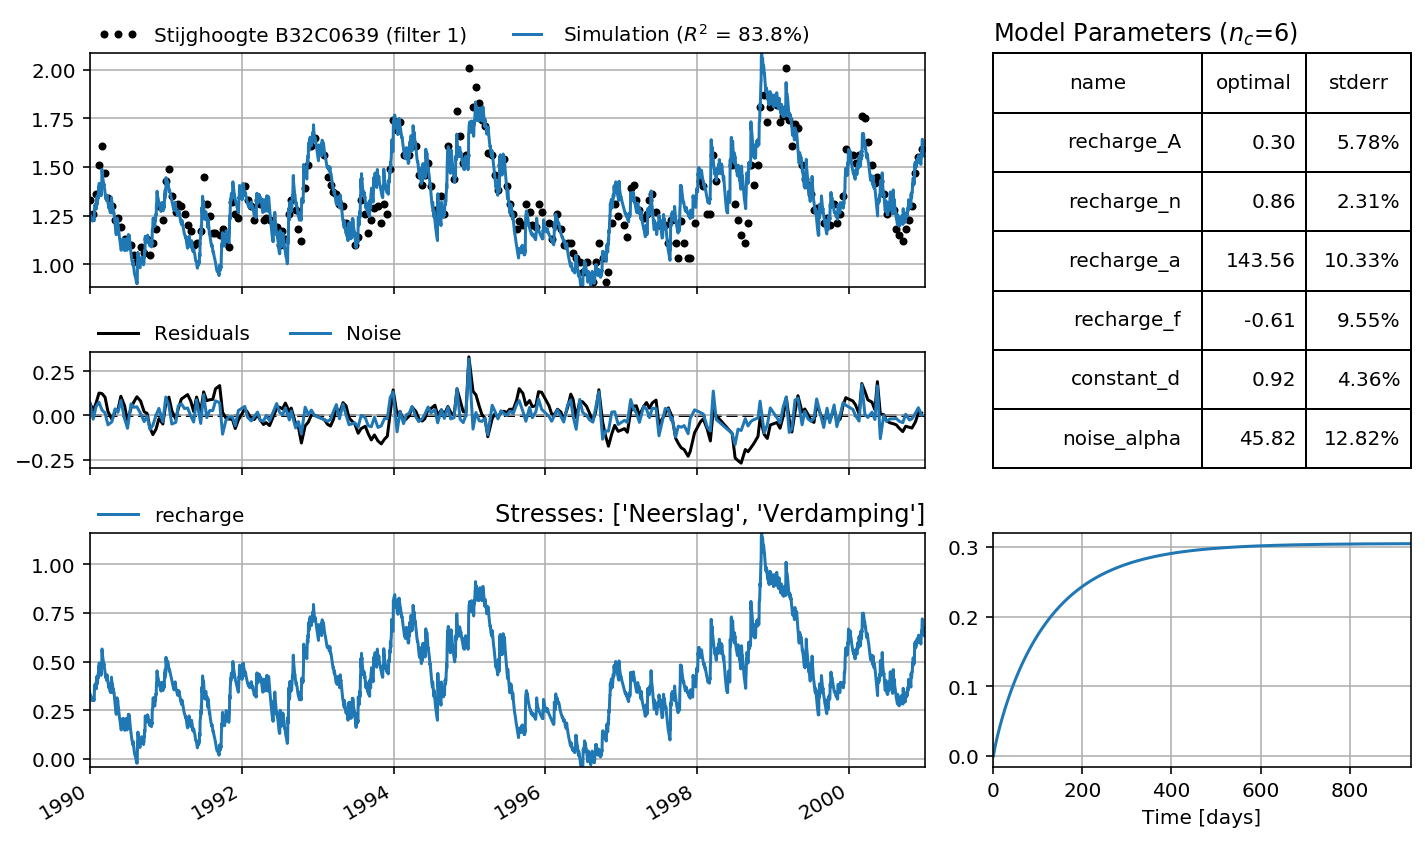

In [6]:
### Voorbeeld van netto neerslagoverschot (N = P-fE) en gamma responsfunctie

# Create the basic Pastas model
ml2 = ps.Model(head, name="lineair")

# Add a recharge model
rch = ps.rch.Linear()
rm = ps.RechargeModel(rain, evap, recharge=rch, rfunc=ps.Gamma, name="recharge")
ml2.add_stressmodel(rm)

# Solve the model
ml2.solve(noise=True, tmin=tmin, tmax=tmax, report=False, fit_constant=fit_constant)
ml2.plots.results(figsize=(10, 6), adjust_height=True);
plt.tight_layout()

In de figuur hierboven is het resultaat van dit model voor de voorbeeld data getoond. Het totaal aantal geschatte parameters in dit model is 6. De geschatte verdampingsfactor is $f=-0.61$. De verdamping is in dit voorbeeld dus 61\% van de Makkink verdamping. Terwijl dit model twee kalibratie parameters minder heeft is de model fit (gemeten als $R^2$) vrijwel gelijk aan het eerste model.

### Niet-lineaire grondwateraanvulling
Bij de derde methode wordt een niet-lineair model gebruikt om grondwateraanvulling te berekenen, die vervolgens ook wordt vertaald in een bijdrage aan de stijghoogtefluctuaties met behulp van een responsfunctie. Verschillende niet-lineaire modellen zijn beschikbaar, zie bijvoorbeeld [Berendrecht et al. (2005)](#Referenties), [Peterson en Western (2014)](#Referenties) en [Collenteur et al. (2020)](#Referenties). Al deze modellen hebben de vorm van een bakje, waar neerslag en verdamping in en uit gaat aan de bovenkant, en grondwateraanvulling uitkomt aan de onderkant. Een voorbeeld van een dergelijk model is hieronder weergegeven. Dit model bevat ook een bakje voor interceptie.

![title](data/conceptual_model.pdf)

Een voordeel van niet-lineaire modellen is dat er rekening wordt gehouden met (niet-lineaire) processen in de wortelzone, waardoor de stijghoogte niet meer lineair reageert op neerslag en verdamping. Dit gebeurt bijvoorbeeld wanneer de verdamping wordt beperkt door het beschikbare bodemvocht ten tijde van droogte, of door de berging van extreme neerslag in de wortelzone. In onderstaande figuur is het resultaat van dit model getoond. Het totaal aantal geschatte parameters van dit model is 8, omdat 3 parameters vast gezet zijn.

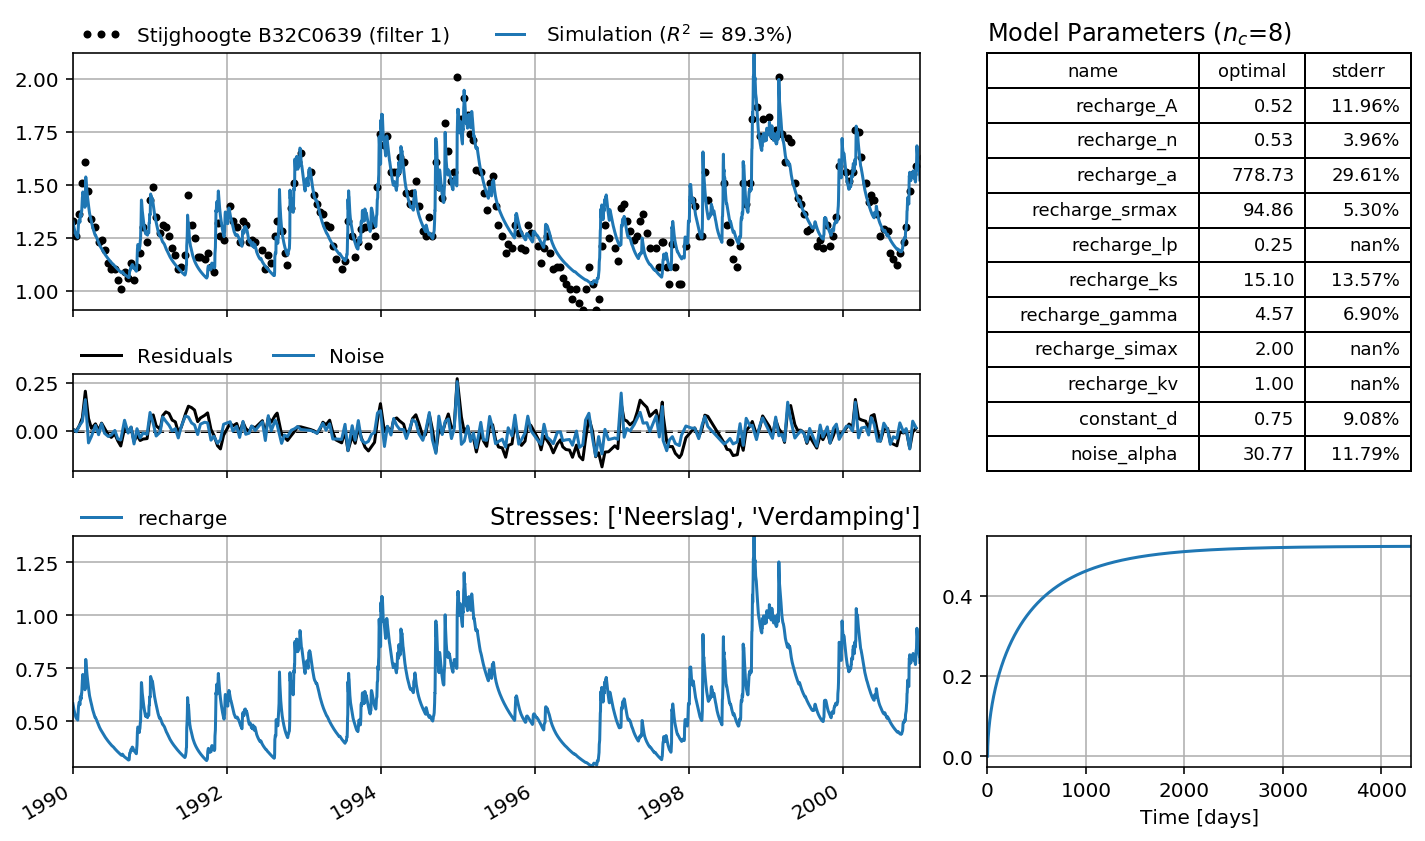

In [7]:
# Voorbeeld van Niet-lineaire grondwateraanvulling en exponentiele response functie
ml3 = ps.Model(head, name="niet-lineair")

# Add a recharge model
rch = ps.rch.FlexModel()
rm = ps.RechargeModel(rain, evap, recharge=rch, rfunc=ps.Gamma, name="recharge")
ml3.add_stressmodel(rm)

# Solve the mod
ml3.set_parameter("constant_d", initial=head.min())  # Start below the lowest head
ml3.solve(noise=True, tmin=tmin, tmax=tmax, initial=True, report=False, fit_constant=fit_constant)
ml3.plots.results(figsize=(10, 6), adjust_height=True);
plt.tight_layout()

Een mogelijk nadeel van niet-lineaire modellen kan een groter aantal vrije parameters zijn. Het is echter vaak mogelijk een aantal parameters vast te zetten en een response functie te gebruiken met minder parameters, waardoor het aantal vrije parameters sterk is te reduceren. De rekentijd van niet-lineaire modellen is tegenwoordig vergelijkbaar met de rekentijd van lineaire modellen.

### Welk model is het beste?
We hebben nu drie modellen voor een stijghoogte tijdreeks die goed verklaart kan worden door neerslag en verdamping. Het model met twee aparte responsen heeft een $R^2=84.5\%$, het lineaire model $R^2=83.8\%$ en het niet-lineaire model $R^2=89.3\%$, elk voor de periode 1990-2001. De modellen ontlopen elkaar dus eigenlijk niet zo veel wat betreft deze fit statistiek. Het is aan de modelleur om nu een van deze modellen te kiezen of deze allemaal te gebruiken.

Een veelgebruikte methode om het "beste" model te selecteren is door de fit van de modellen buiten de kalibratieperiode te berekenen (zie ook de notebook over "Beoordeling"). In de figuur hieronder is met elk model de stijghoogte voor een periode na de kalibratieperiode gesimuleerd (2001-2006), de zogeheten validatieperiode. In de legenda is de determinatie coefficient weergegeven als percentage. Nu is het model met de twee responsen het "beste" model volgens de $R^2$ statistiek ($R^2=88.0\%$), en hebben het lineaire en niet-lineaire model een iets mindere fit ($R^2=85.8\%$).

De model fits zijn in dit voorbeeld zeer vergelijkbaar. De modelleur kan er in dit geval bijvoorbeeld voor kiezen het model met het laagste aantal parameters te kiezen. Dit aantal is het laagste voor het lineaire model ($n=6$), en de andere twee modellen hebben beide meer parameters hebben (beide $n=8$). Een ander type motivatie zou kunnen afhangen van het doel van de modellering. Wanneer we bijvoorbeeld vooral geinteresseerd zijn in lage grondwaterstanden lijken de lineaire modellen beter toepasbaar, terwijl hoge grondwaterstanden juist beter met het niet-lineaire model worden gesimuleerd. Hier is duidelijk dat de keuze voor een specifiek model afhangt van het doel van de modellering.

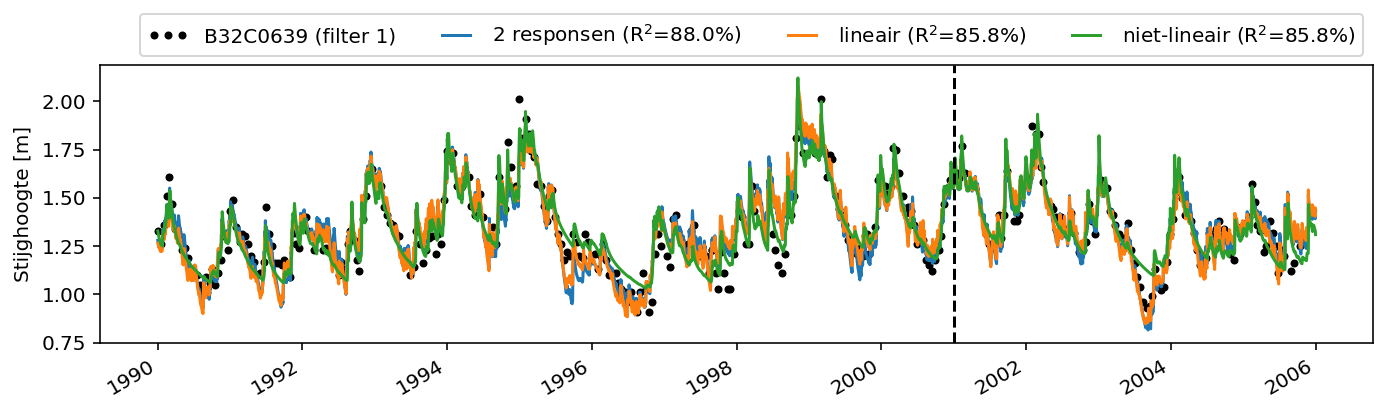

In [8]:
ax = ml1.oseries.series[tmin:].plot(marker=".", linestyle=" ", color="k", figsize=(10,3))

labels = ["B32C0639 (filter 1)"]
for ml in [ml1, ml2, ml3]:
    ml.simulate(tmax="2006").plot()
    labels.append("{} (R$^2$={}%)".format(ml.name, (ml.stats.rsq(tmin=tmax, tmax="2006")*100).round(1)))
ax.axvline(pd.Timestamp(tmax), color="k", linestyle="--")
plt.legend(labels, ncol=4, bbox_to_anchor=(1, 1.22), numpoints=3)
plt.ylabel("Stijghoogte [m]");
plt.tight_layout()

### Dikkere onverzadigde zone
Uit het voorgaande voorbeeld bleek dat een linear model voor deze peilbuis en stijghoogte tijdreeks beter in staat is de lage stijghoogtes te simuleren. De grondwaterspiegel in dit voorbeeld ligt dichtbij het maaiveld, wat betekend dat de wortelzone (of eigenlijk de vegetatie) water op kan nemen uit het grondwater. Het lineaire model kan een negatieve flux voor het neerslagoverschot simuleren, het niet-lineaire model dat in het voorbeeld hierboven is gebruikt dit niet kan. [Peterson et al (2014)](#Referenties) hebben een niet-lineair model uitgewerkt voor diepe grondwaterstanden en diepe wortelsystemen in Austrialïe, waarbij ook water uit het grondwater wordt onttrokken en kan verdampen.

In Nederland zullen dergelijke diepe wortelsystemen echter minder vaak voorkomen, en beweegt bodemwater in systemen met dikke onverzadigde zones van de wortelzone naar het grondwater. Wanneer er geen verdamping vanuit het grondwater plaatsvindt kan een niet-lineair model helpen om de stijghoogte te modelleren. Of het toepassen van een niet-lineaire model de simulatie van een  stijghoogte tijdreeks verbetert is onderdeel van onderzoek en zal per peilbuis moeten worden vastgesteld. Ook hier dient het aanbeveling deze modelvorm eenvoudigweg te testen en te varieren zoals bij de responsfuncties.

---

In onderstaand voorbeeld voor is een stijghoogte tijdreeks gemodelleerd met een dikkere onverzadigde zone. De tijdreeks is gemeten in peilbuis B27D0140 (filter 1) nabij Oldebroek ten noorden van de Veluwe. In dit voorbeeld is de simulatie van de stijghoogte beter door het gebruik van een niet-lineair model voor de berekening van de grondwateraanvulling.

In [9]:
head = ps.read_dino("data/B27D0140001_1.csv")
prec = ps.read_knmi("data/neerslaggeg_OLDEBROEK_336.txt", variables="RD").series * 1e3
prec.index = prec.index.round("D")
prec = prec.asfreq("D")
evap = ps.read_knmi("data/etmgeg_275.txt", variables="EV24").series.asfreq("D") * 1e3

ml = ps.Model(head, name="B27D0140_1")
rch = ps.rch.FlexModel()
rm = ps.RechargeModel(rain, evap, recharge=rch, rfunc=ps.Gamma, name="rch")
ml.add_stressmodel(rm)

# Solve the model
#ml.set_parameter("constant_d", initial=head.series.min())  # Start below the lowest head
ml.set_parameter("rch_kv", vary=True)

ml.solve(noise=False, tmin="2000", tmax="2015", report=False, fit_constant=fit_constant)
r2_nl = round(ml.stats.rsq(), 2)
# ml.set_parameter("rch_srmax", vary=False)
# ml.solve(noise=True, initial=False,  tmin="2005", tmax="2015", report=False)
sim = ml.simulate(tmax="2018")

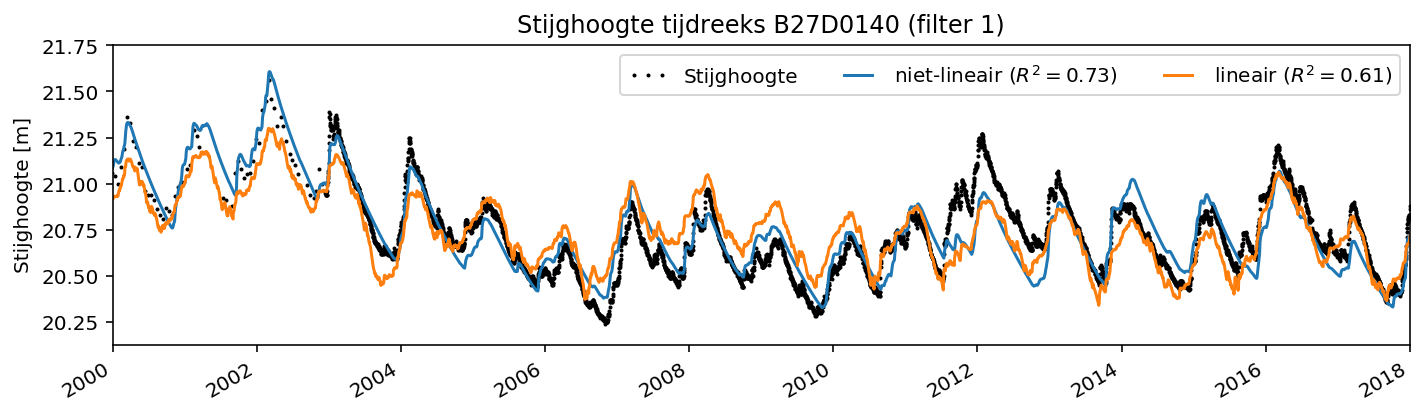

In [10]:
ml = ps.Model(head, name="B27D0140_1")
rch = ps.rch.Linear()
rm = ps.RechargeModel(prec, evap, recharge=rch, rfunc=ps.Gamma, name="rch")
ml.add_stressmodel(rm)

# Solve the model
#ml.set_parameter("constant_d", initial=head.series.min())  # Start below the lowest head
ml.solve(noise=False, tmin="2000", tmax="2018", report=False, fit_constant=fit_constant)
r2_l = round(ml.stats.rsq(), 2)
# Plot de resultaten
fig, ax = plt.subplots(1, 1, figsize=(10,3))
head.plot(ax=ax, marker=".", color="k", linestyle=" ", markersize=2)

ax.plot(sim)
ml.simulate(tmax="2018").plot(ax=ax)
ax.set_xlim(["2000", "2018"])
#ax.set_ylim(18.2, 20.0)
ax.set_ylabel("Stijghoogte [m]")
ax.set_title("Stijghoogte tijdreeks B27D0140 (filter 1)")
ax.legend(["Stijghoogte",  f"niet-lineair ($R^2=${r2_nl})", f"lineair ($R^2=${r2_l})"], ncol=4, loc=1, numpoints=3);
plt.tight_layout()

## Drempel niet-lineariteit
Een veelvoorkomend fenomeen in Nederland is drempel niet-lineariteit (zie bv. [Berendrecht et al. (2004) en von Asmuth et al. 2012)](#Referenties)). Daarbij reageert een grondwatersysteem anders op neerslag nadat een bepaalde grenswaarde in de stijghoogte is overschreden. Onder andere [Knotters et al. (1999)](#Referenties) hebben hiervoor een model ontwikkeld, het zogeheten TARSO model, waarbij de respons op neerslagoverschot afhangt van de stijghoogte boven of onder een bepaalde drempelwaarde. Wanneer de stijghoogte boven deze drempelwaarde komt, kan het bijvoorbeeld zo zijn dat er afstroming naar het oppervlaktewater plaatsvindt (bv. een sloot die anders droog staat). Of er sprake is van drempel niet-lineariteit kan worden vastgesteld door:

1. een visuele inspectie van de stijghoogte tijdreeks, 
3. het plotten van een histogram van de stijghoogte metingen,
2. en het testen van verschillende modelstructuren.

---

Als voorbeeld kijken we naar de stijghoogte tijdreeks gemeten in peilbuis B28H1804 (filter 2) in de buurt van Weerselo. De gegevens in Dinoloket laten zien dat het maaiveld bij dit punt of 19.44 meter t.o.v. NAP ligt. In onderstaande figuur is de stijghoogte tijdreeks en een histogram van de reeks afgebeeld voor een visuele inspectie van de tijdreeks (stappen 1 & 2). 

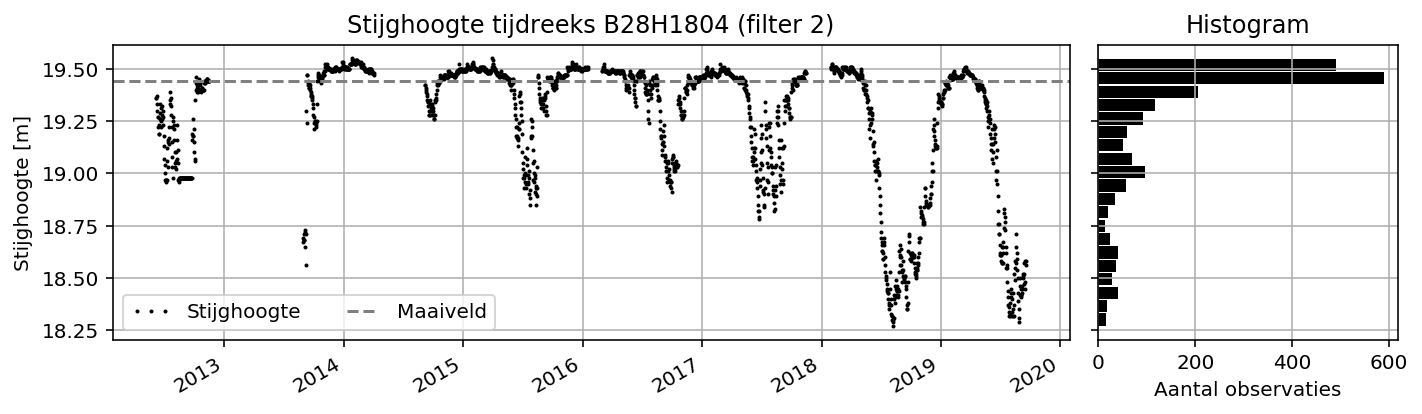

In [11]:
head = ps.read_dino("data/B28H1804001_1.csv").series

fig = plt.figure(figsize=(10,3))

gs = GridSpec(1, 4, figure=fig)

ax1 = fig.add_subplot(gs[0, :-1])
ax2 = fig.add_subplot(gs[0, -1], sharey=ax1)

head.plot(ax=ax1, marker=".", color="k", linestyle=" ", markersize=2)
ax1.grid()
ax2.grid()
plt.hist(head, orientation="horizontal", bins=20, color="k", rwidth=0.9)
ax1.axhline(19.44, linestyle="--", color="gray")
ax1.set_title("Stijghoogte tijdreeks B28H1804 (filter 2)")
ax1.set_ylabel("Stijghoogte [m]")
ax2.set_title("Histogram");
ax2.set_xlabel("Aantal observaties")
ax1.legend(["Stijghoogte", "Maaiveld"], ncol=2, numpoints=3)
plt.tight_layout()

Uit bovenstaande plots is af te leiden dat er mogelijk sprake is van drempel niet-lineariteit. De stijghoogte reeks is afgevlakt rond 19.50-19.75 en de histogram laat een duidelijk een scheve verdeling zien. Op basis van deze visuele inspectie kunnen we besluiten om twee modellen te proberen: de eerste met een simpel neerslagoverschot ($N = P - fE$) en een tweede met drempel niet-lineariteit (hier, het TARSO model, [Knotters et al., 1999](#Referenties)). Vervolgens kan dan worden beoordeeld welk model beter is.

Onderstaande figuur geeft de resultaten van de twee modellen weer. Het lineaire model geeft een structurele overschatting van de hoge stijghoogtes, waar het model met drempel niet-lineairiteit netjes de gemeten grondwaterstand volgt.

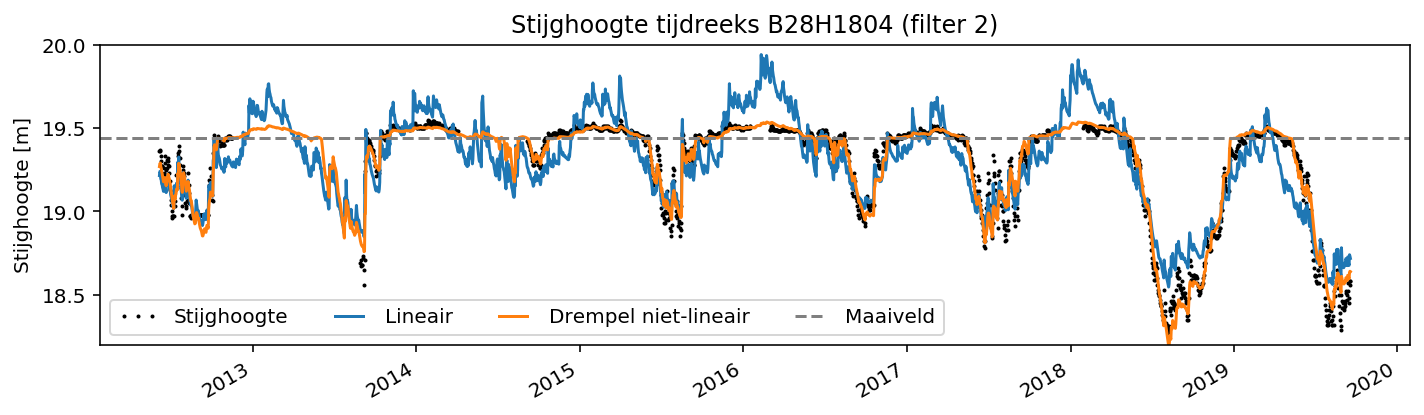

In [12]:
prec = pd.read_csv("data/RD Weerselo.csv", index_col=0, parse_dates=True, squeeze=True) * 1e3
evap = pd.read_csv("data/EV24 Twenthe.csv", index_col=0, parse_dates=True, squeeze=True) * 1e3

ml = ps.Model(head, name="B28H1804_2")
rm = ps.RechargeModel(prec, evap, name="recharge", rfunc=ps.Gamma, recharge=ps.rch.Linear())
ml.add_stressmodel(rm)
# the model is already solved, but we solve it again to be certain
ml.solve(noise=False, report=False, fit_constant=fit_constant)
sim = ml.simulate()

# Plot van lineair model versus een drempel niet-lineair model.
sm = ml.stressmodels['recharge']
prec = sm.stress[0]
evap = sm.stress[1]

# delete all the stressmodels, the constant and the transform
ml.del_stressmodel('recharge')
ml.del_constant()

# then add a TarsoModel
sm = ps.TarsoModel(prec, evap, ml.oseries)
ml.add_stressmodel(sm)

# and solve again
ml.solve(noise=False, report=False)

# Plot de resultaten
fig, ax = plt.subplots(1, 1, figsize=(10,3))
head.plot(ax=ax, marker=".", color="k", linestyle=" ", markersize=2)

ax.plot(sim)
ml.simulate().plot(ax=ax)
ax.set_ylim(18.2, 20.0)
ax.set_ylabel("Stijghoogte [m]")
ax.set_title("Stijghoogte tijdreeks B28H1804 (filter 2)")
ax.axhline(19.44, linestyle="--", color="gray")
ax.legend(["Stijghoogte",  "Lineair", "Drempel niet-lineair", "Maaiveld"], ncol=4, loc=3, numpoints=3);
plt.tight_layout()

## Andere verklarende variabelen
Tot op dit punt hebben we gekeken naar stijghoogte tijdreeksen die zich goed laten verklaren door neerslag en verdamping. In veel gevallen zijn echter andere verklarende tijdreeksen nodig om de stijghoogte goed te kunnen modelleren. Twee invloeden die vaak belangrijk zijn, zijn oppervlaktewaterpeilen en grondwaterontrekkingen. In de volgende twee secties wordt beschreven hoe de effecten van deze invloeden kunnen worden gemodelleerd.

### Oppervlaktepeil als verklarende tijdreeks
In grote delen van Nederland worden de stijghoogten beïnvloed door oppervlaktewaterpeilen. Dit kunnen grote rivieren en meren als de Rijn en het Ijsselmeer zijn, maar ook kleinere vennen en slootjes in de polder. Het is niet ongebruikelijk dat het nodig is een tijdreeks van een nabijgelegen oppervlaktewaterpeil toe te voegen aan het tijdreeksmodel om de stijghoogte goed te kunnen modelleren. 

We kunnen dit wederom doen door de tijdreeks van het gemeten oppervlaktewaterpeil te vertalen naar een bijdrage aan de stijghoogtefluctuaties met behulp van een responsfunctie. De repons functie beschrijft dan de reactie van de stijghoogte op fluctuaties in het oppervlaktewaterpeil. Het is aan te bevelen om deze tijdreeks eerst te normaliseren door bijvoorbeeld het gemiddelde of de mediaan er van af te trekken. We zijn immers enkel geintereseerd in de veranderingen in het oppervlaktewaterpeil en niet in het absolute niveau. Meer informatie over normaliseren van tijdreeksen is te vinden in het notebook over "Voorbewerking".

---

Als voorbeeld modelleren we de stijghoogte tijdreeks gemeten in peilbuis 40CP0393 (filter 4). Eerst maken we een model met enkel neerslag en verdamping als verklarende variabelen. Deze worden vertaald in stijghoogte fluctuaties met een lineair neerslagoverschot model en een Gamma responsfunctie. Dit model levert de volgende simulatie van de stijghoogte op.

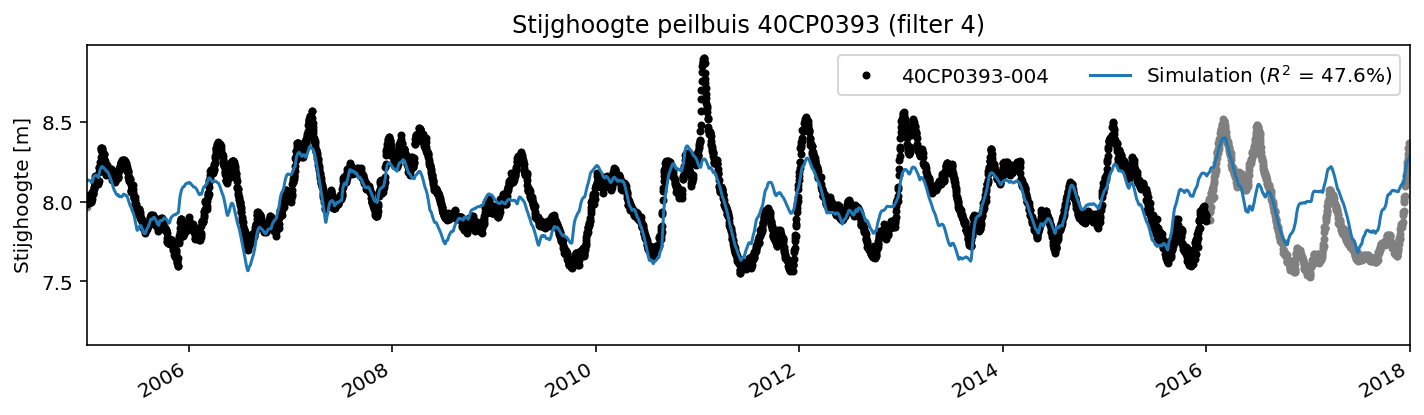

In [13]:
# Code met dit model hier
head = pd.read_csv("data/40CP0393-004.csv", index_col=0, parse_dates=True, squeeze=True).resample("D").mean().dropna()
prec = pd.read_csv("data/RD_Nijmegen.csv", index_col=0, parse_dates=True) * 1e3
evap = pd.read_csv("data/EV24_Deelen.csv", index_col=0, parse_dates=True) * 1e3

ml = ps.Model(head, name="40CP0393 (filter 4)")
sm = ps.RechargeModel(prec, evap, name="rch", recharge=ps.rch.Linear(), rfunc=ps.Gamma)
ml.add_stressmodel(sm)

ml.solve(tmin="2005", tmax="2016", report=False, fit_constant=fit_constant)
ax = ml.plot(figsize=(10, 3), tmax="2018");
ax.set_title("Stijghoogte peilbuis 40CP0393 (filter 4)")
ax.set_ylabel("Stijghoogte [m]")
plt.tight_layout()

Uit bovenstaande figuur blijkt duidelijk dat het neerslagoverschot niet genoeg is om de stijghoogte fluctuaties te verklaren. Uit de hydrologische systeem analyse van het studiegebied blijkt dat de peilbuis dichtbij een rivier ligt. We kunnen dan de rivierwaterstand als verklarende tijdreeks aan het model toevoegen en kijken of dit de simulatie van de stijghoogte verbetert. We kiezen hier voor de Gamma responsfunctie met drie parameters om het oppervlaktewaterpeil te vertalen in stijghoogtefluctuaties.

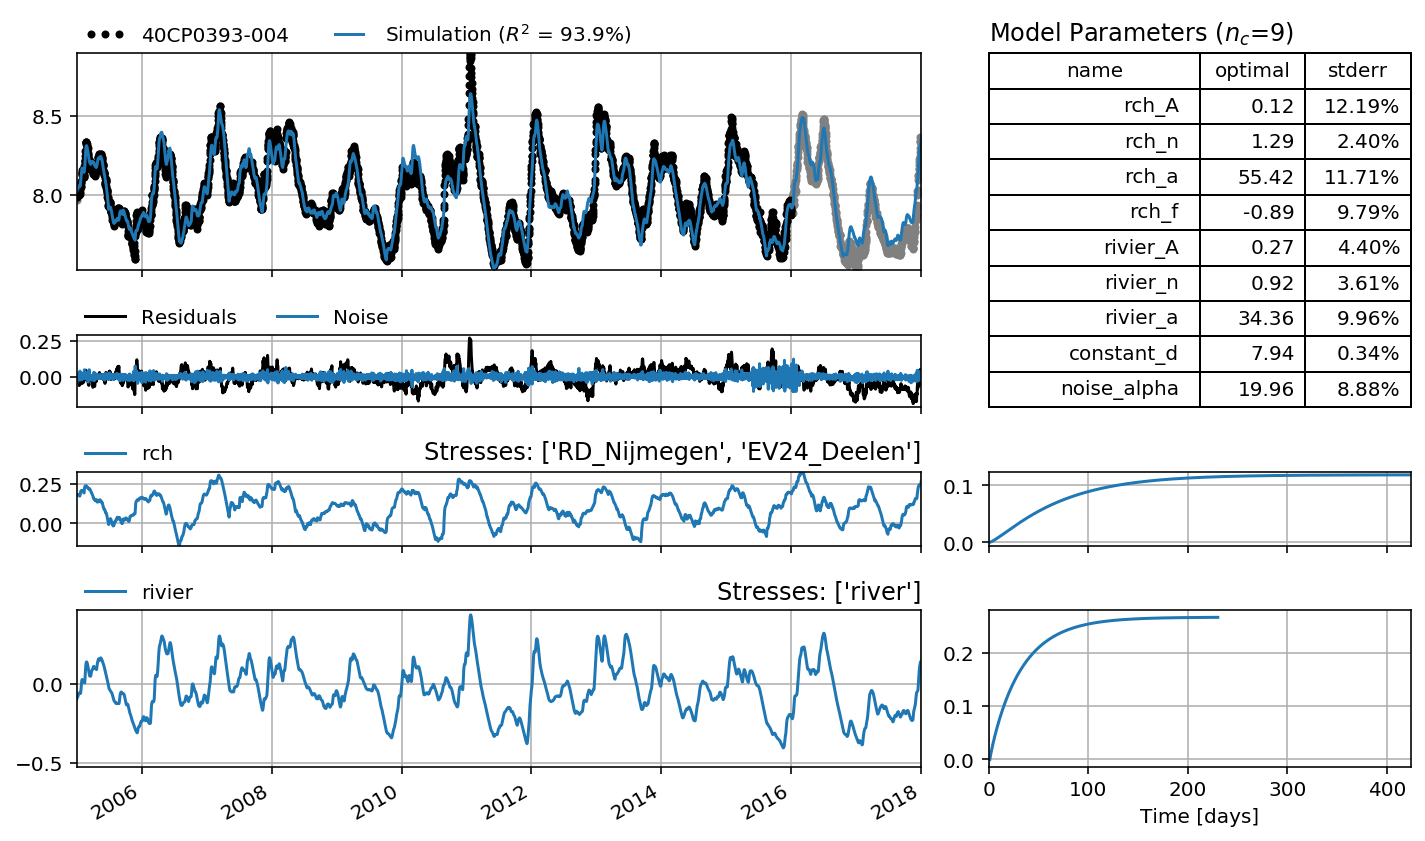

In [14]:
rivier = pd.read_csv("data/40CP0393-rivier.csv", index_col=0, parse_dates=True, squeeze=True)
sm2 = ps.StressModel(rivier, name="rivier", rfunc=ps.Gamma)
ml.add_stressmodel(sm2)

ml.solve(tmin="2005", tmax="2016", report=False, fit_constant=fit_constant)
ml.plots.results(figsize=(10, 6), tmax="2018", adjust_height=True);
plt.tight_layout()

Het model laat een duidelijke verbetering zien in de fit tussen de gesimuleerde en de gemeten stijghoogte. De fit, hier uitgedrukt als $R^2$, is gestegen van $R^2=61$\% naar $R^2=94.2$\%. Het toevoegen van het oppervlaktewaterpeil levert hier dus een duidelijke verbetering op.

De gekalibreerde responsfunctie voor het effect van de rivier lijkt erg op een exponentiele responsfunctie, te zien aan de blok respons en de waarde van parameter $rch\_n$ die bijna 1 is. Dit betekent dat de stijghoogte vrijwel instantaan reageert op de rivierwaterstand. Wanneer dit het geval is, verdient het aanbeveling de Gamma responsfunctie te vervangen door de exponentiele responsfunctie. Dit scheelt 1 kalibratie parameter in het model, en levert hetzelfde model op. Wanner de fit gelijk is, zal een model met minder parameters de voorkeur hebben over een model met meer parameters. Onderstaande figuur toont het model waar een exponentiele responsfunctie gebruikt is in plaats van de Gamma functie. Het resultaat laat zien dat dit een vergelijkbaar model oplevert, maar met 1 parameter minder. 

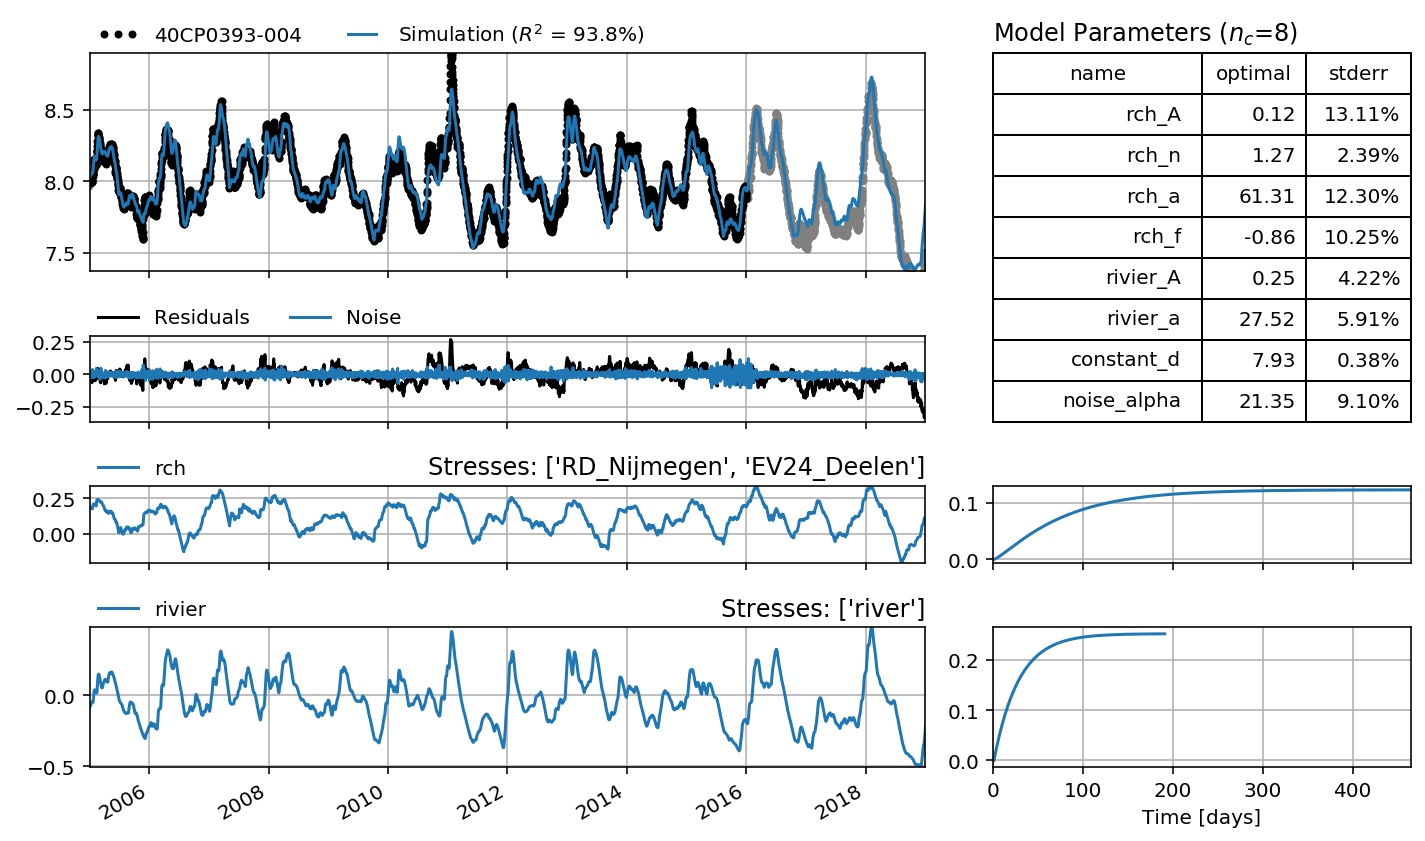

In [15]:
ml.del_stressmodel("rivier")
sm2 = ps.StressModel(rivier, name="rivier", rfunc=ps.Exponential)
ml.add_stressmodel(sm2)

ml.solve(tmin="2005", tmax="2016", report=False, fit_constant=fit_constant)
ml.plots.results(figsize=(10, 6), tmax="2019", adjust_height=True);
plt.tight_layout()

Zowel de grondwateraanvulling als het oppervlaktewaterpeil is afhankelijk van de neerslag (als het hard regent is vaak het rivierpeil ook hoog). Dit kan er voor zorgen dat de parameters van deze modelonderdelen sterk gecorreleerd zijn en de  bijdragen aan de stijghoogte fluctuaties lastig van elkaar te onderscheiden zijn. 

In het voorgaande model is dit visueel al zichtbaar, en de correlatie tussen de twee bijdragen is $r=0.60$. Des te sterker de correlatie tussen deze twee bijdragen, des te lastiger is het om een deel van de stijghoogtefluctuatie toe te kennen aan 1 van deze invloeden. Dit kan de mogelijkheid beperken om precieze uitspraken te doen over het effect van een bepaalde invloed op de stijghoogte.

In [16]:
bijdrage_rivier = ml.get_contribution("rivier")
bijdrage_rch = ml.get_contribution("rch")
bijdrage_rch.corr(bijdrage_rivier);

### De invloed van een grondwaterontrekking bepalen

Grondwater wordt door heel Nederland gebruikt voor de productie van drinkwater en als bron van irrigatiewater. Voor het modelleren van stijghoogte tijdreeksen in gebieden waar (in het verleden of nu) grondwater wordt ontrokken is het vaak nodig om een tijdreeks van deze ontrekking mee te nemen. Enige voorbewerking van deze tijdreeksen is over het algemeen nodig, bijvoorbeeld om tijdreeksen met maandelijkse debiet totalen terug te brengen naar een tijdreeks met een gelijke tijdstap (bv. dagsommen). Ook kan het helpen de debietsreeks uit te drukken in Miljoen kuub per tijdstap, om te voorkomen dat extreem kleine parameter waarden worden gesimuleerd. Meer over deze voorbewerking en kalibratie is te vinden in de notebooks over "Voorbewerking" en "Modelkalibratie".

---

Als voorbeeld kijken we naar een peilbuis XX (filter XX) in de omgeving van een grondwater pompstation in Vierlingsbeek / Boxmeer. Op basis van de hydrologische systeem analyse is te verwachten dat neerslag, verdamping, en mogelijk de grondwateronttrekking als verklarende variabelen in het model moeten worden meegenomen. We kiezen er hier voor met een simpel model te beginnen op basis van neerslag en verdamping. Wanneer dit genoeg is om de stijghoogte tijdreeks te modelleren zijn we klaar en, wanneer dit niet het geval is, voegen we de debietreeks van het pompstation toe als verklarende variabelen. Merk op dat deze werkwijze ook is om te keren (starten met een complex model en daarna invloeden verwijderen), de modelleur dient een keuze te maken voor de volgorde van de modelbouw.

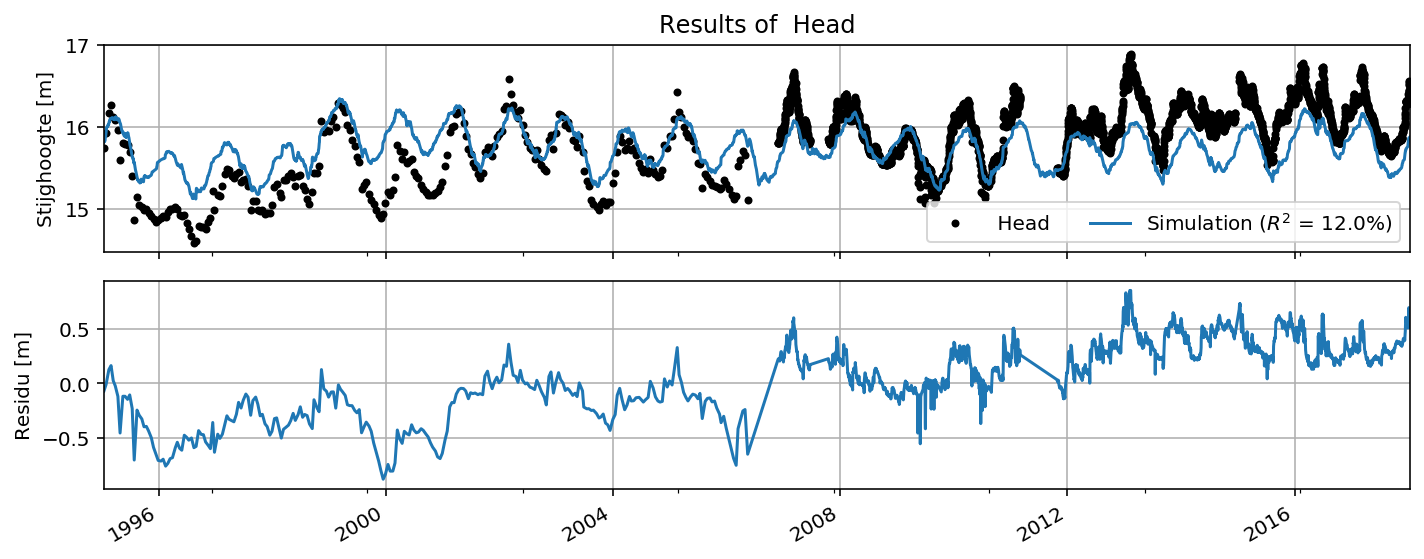

In [17]:
head = pd.read_csv("data/head_wellex.csv", index_col="Date", parse_dates=True, squeeze=True)
rain =  pd.read_csv("data/prec_wellex.csv", index_col="Date", parse_dates=True) * 1e3
evap =  pd.read_csv("data/evap_wellex.csv", index_col="Date", parse_dates=True) * 1e3
well =  pd.read_csv("data/well_wellex.csv", index_col="Date", parse_dates=True) / 1e6

ml = ps.Model(head)
sm = ps.RechargeModel(rain, evap, name="recharge",
                      rfunc=ps.Exponential, recharge=ps.rch.Linear())
ml.add_stressmodel(sm)
ml.solve(noise=True, initial=False, report=False, fit_constant=fit_constant)

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(10,4), sharex=True)
ml.plot(ax=ax1)
ml.residuals().plot(ax=ax2)
ax1.grid()
ax2.grid()
ax1.set_ylabel("Stijghoogte [m]")
ax2.set_ylabel("Residu [m]")
plt.tight_layout()

#print((ml.stats.pearsonr(weighted=True).round(2)**2).round(2))  # Want ongelijke tijdstappen

Bovenstaande figuur toont de gemeten en gesimuleerde stijghoogtetijdreeks in de bovenste plot, en de modelresiduën in de onderste plot. In de modelresiduën is een duidelijke trend over de tijd te zien, wat wijst op het mogelijk ontbreken van een invloed. We voegen daarom de tijdreeks van het ontrekkingsdebiet toe aan het model. Deze wordt vertaald naar een bijdrage aan de stijghoogtefluctuaties met behulp van een Gamma response functie. Dit levert het volgende model op.

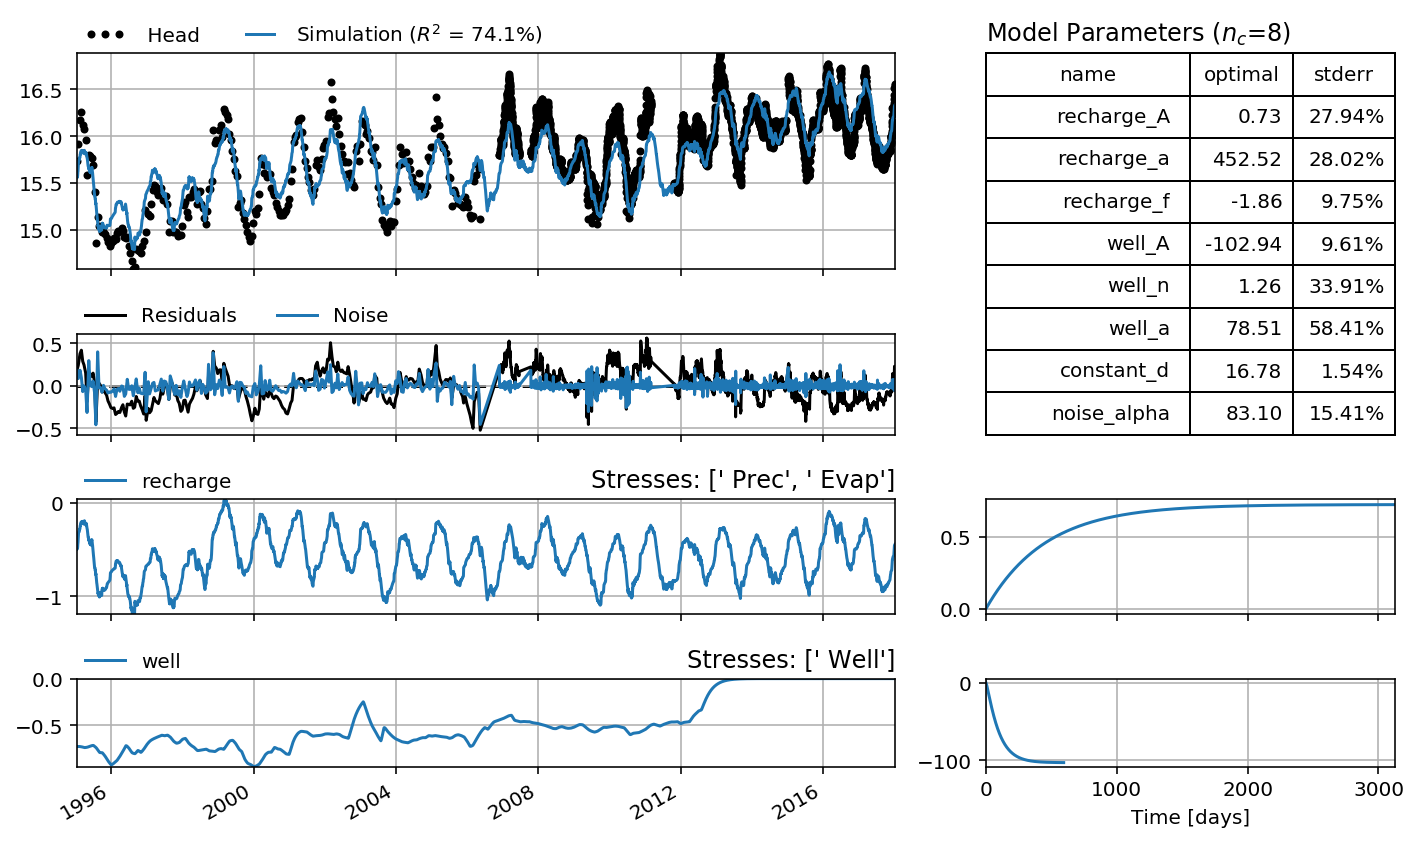

In [18]:
sm = ps.StressModel(well, rfunc=ps.Gamma, name="well", settings="well", up=False)
ml.add_stressmodel(sm)
ml.solve(noise=True, initial=False, report=False, fit_constant=fit_constant)
ml.plots.results(figsize=(10, 6), adjust_height=True);

Bovenstaande figuur laat duidelijk zien dat de fit van het model wordt verbeterd door het toevoegen de grondwaterontrekking aan het model. Dit geeft ook de mogelijk om de invloed van het ontrekken van grondwater op de stijghoogte in te schatten. De stap respons kan een indicatie geven van de te verwachten verlaging (verhoging) door het extra (minder) minder ontrekken van een hoeveelheid grondwater, onder de aanname dat de stijghoogte op eenzelfde wijze reageert op een verhoging of verlaging in het debiet. In dit model is gebruik gemaakt van een Gamma responsfunctie met drie parameters. Een andere responsfunctie die gebruikt kan worden is bijvoorbeeld de Hantush functie. De volgende figuur toont het modelresultaat wanneer een Hantush responsfunctie wordt gebruikt voor de ontrekking.

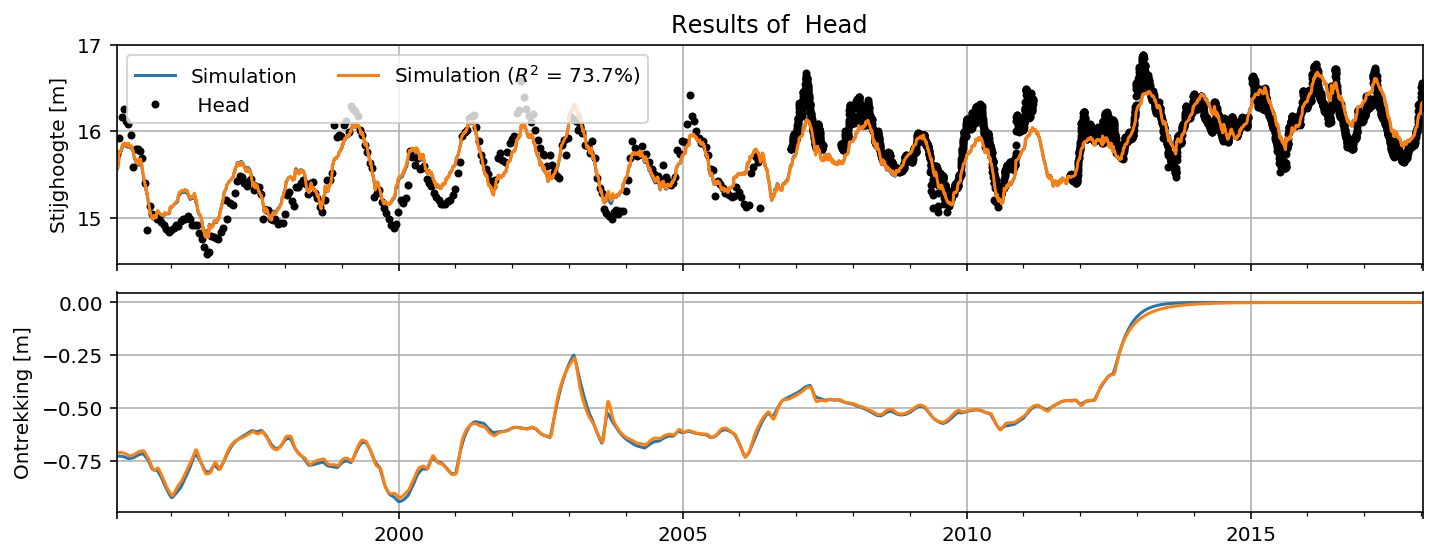

In [19]:
well1 = ml.get_contribution("well")
sim = ml.simulate()

ml.del_stressmodel("well")
sm = ps.StressModel(well, rfunc=ps.Hantush, name="well", settings="well", up=False)
ml.add_stressmodel(sm)
ml.solve(noise=True, initial=False, report=False, fit_constant=fit_constant)

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(10,4), sharex=True)
sim.plot(ax=ax1)
ml.plot(ax=ax1)

well1.plot(ax=ax2)
ml.get_contribution("well").plot(ax=ax2)

ax1.grid()
ax2.grid()
ax1.set_ylabel("Stijghoogte [m]")
ax2.set_ylabel("Ontrekking [m]")
plt.tight_layout()

In dit voorbeeld maakt het weinig verschil welke van deze twee responsfuncties wordt gebruikt om het effect van de ontrekking op de stijghoogte te modelleren.

Tot slot een opmerking over het modelleren van ontrekkingen en de variatie in de debietstijdreeks. Om de invloed van het ontrekken van grondwater op de stijghoogte vast te stellen is het belangrijk dat er enige variatie aanwezig is in de debiet tijdreeks. Er bestaan helaas (nog) geen vuistregel om te bepalen hoeveel variatie in een verklarende tijdreeks genoeg is om de invloed goed te kunnen vast stellen. Of de debietsreeks een periode zonder ontrekken moet bevatten voor het vaststellen van de stijging in de stijghoogtes als gevolg van het stoppen van pompen is bijvoorbeeld onbekend.

### Meerdere grondwaterontrekkingen

Wanneer meerdere pompstations in een gebied aanwezig zijn is het goed mogelijk dat de ruwe debietsreeksen sterk aan elkaar gecorreleerd zijn. Het is dan lastig om de invloed van deze reeksen van elkaar te onderscheiden. In dit geval is het mogelijk om de ontrekkingen te vertalen in stijghoogtefluctuaties met een enkele responsfunctie die geschaald is met de afstand van de pompput tot de peilbuis. Een dergelijk model en toepassing is bijvoorbeeld ook beschreven in [Berendrecht et al. (2006)](#Referenties). Dit scheelt een aantal parameters, terwijl vaak de fit van het model zeer vergelijkbaar zal zijn. Wanneer met meerdere ontrekkingen wordt gewerkt die water oppompen uitzelfde watervoerende pakket is het dus aan te bevelen een dergelijke model structuur te gebruiken en zo het aantal (te schatten) parameters laag te houden. In het voorbeeld hieronder is dit uitgewerkt.

---

De builbuis XX ligt op 2282 meter afstand van pompput 1 en op 2784 meter afstand van pompput 2.  De ontrekkingsdebieten in enige mate aan elkaar gecorreleerd ($r=0.65$). Beide ontrekkingen vinden plaats in hetzelfde watervoerende pakket. De responsen van de stijghoogte op beide ontrekkingen zouden dus aan elkaar gerelateerd moeten zijn. Hieronder is het hierboven beschreven model toegepast op dit voorbeeld. 

In [20]:
head = pd.read_csv("data/mw_head.csv", index_col=0, parse_dates=True, squeeze=True)
prec = pd.read_csv("data/mw_prec.csv", index_col=0, parse_dates=True, squeeze=True)
evap = pd.read_csv("data/mw_evap.csv", index_col=0, parse_dates=True, squeeze=True)
well1 = pd.read_csv("data/mw_well1.csv", index_col=0, parse_dates=True, squeeze=True) / 1e6
well2 = pd.read_csv("data/mw_well2.csv", index_col=0, parse_dates=True, squeeze=True) / 1e6

# fig, [ax1, ax2] = plt.subplots(2,1, figsize=(10,3), sharex=True, sharey=True)
# well1.plot(ax=ax1)
# well2.plot(ax=ax2);
well1.corr(well2);

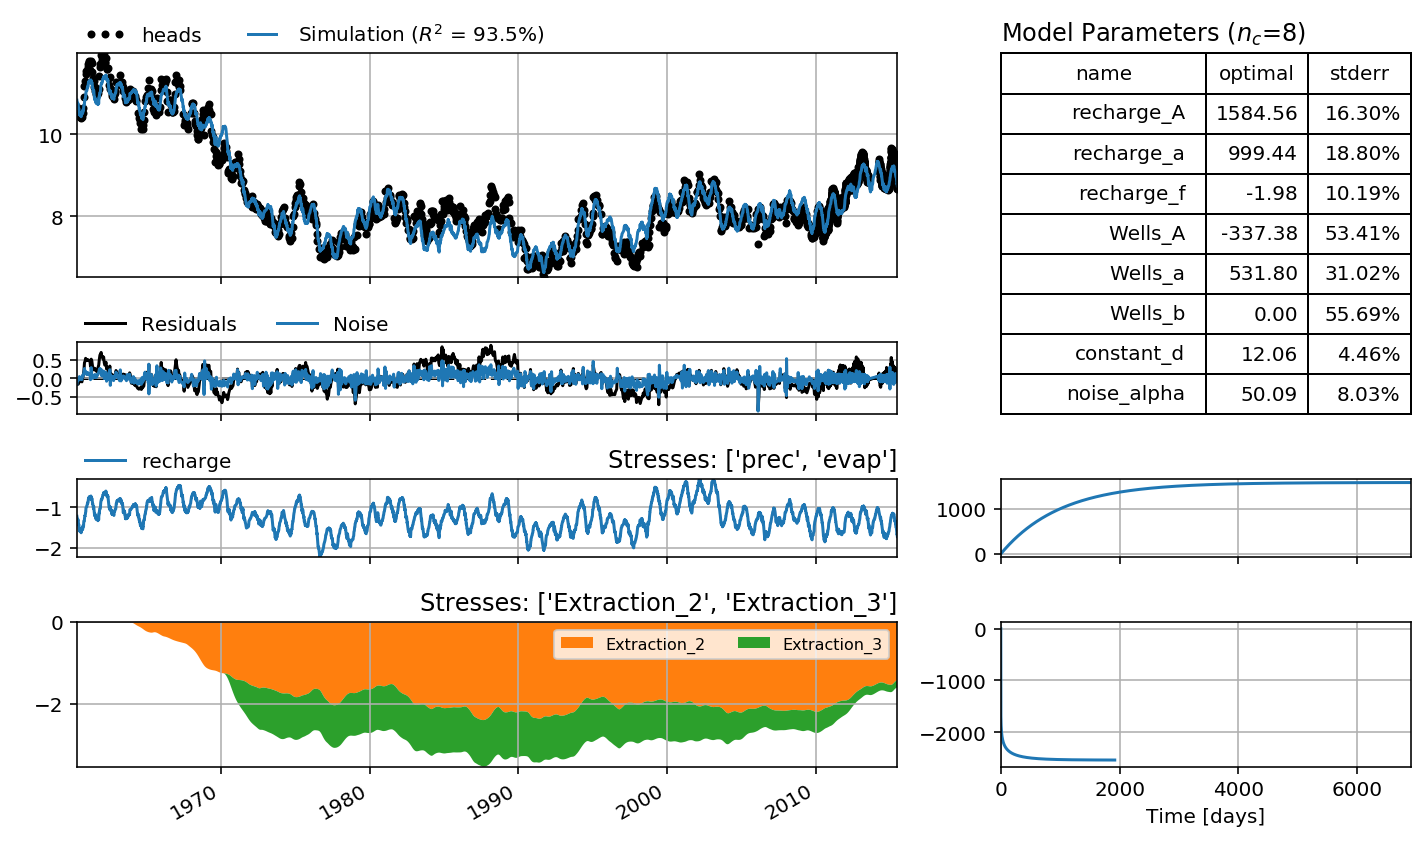

In [21]:
ml = ps.Model(head, name="XXX (filter X)")

sm = ps.RechargeModel(prec, evap, name="recharge", rfunc=ps.Exponential)
distances = [2282, 2784]  #Afstanden van peilbuis tot pomputten
w = ps.WellModel([well1, well2], ps.HantushWellModel, "Wells", distances, settings="well")

ml.add_stressmodel([sm, w])

ml.solve(solver=ps.LmfitSolve, report=False, fit_constant=fit_constant)
ml.plots.stacked_results(figsize=(10, 6), adjust_height=True);
plt.tight_layout()

Zoals blijkt de figuur hierboven is het model goed in staat de stijghoogte te simuleren, terwijl het aantal geschatte parameters (n=8) laag blijft. Wanneer meerdere ontrekkingen in een gebied aanwezig zijn dient het aanbeveling een dergelijk model toe te passen zodat het aantal te schatten parameters beperkt blijft. 

## Veranderingen in het systeem

Veranderingen in de stijghoogte fluctuaties dienen niet altijd gemodelleerd te worden met behulp van een verklarende tijdreeks. Er zijn tal van invloeden te bedenken waarbij simpelweg geen tijdreeks van een verandering beschikbaar is, maar wel een kwalitatieve beschrijving van de verandering of het moment van de verandering. Dit kan bijvoorbeeld een peilopzet zijn in een polder waar het oppervlaktewaterpeil niet wordt gemeten, een verandering van het type vegetatie in de loop van de observatie periode, of het langzaam dichtslibben van de rivierbodem waardoor de respons op fluctuaties in het oppervlaktewaterpeil verandert in de tijd. Grofweg drie methoden zijn te onderscheiden om rekening te houden met dit type veranderingen:

- het toevoegen van een lineaire trend over een bepaalde periode
- het toevoegen van een staptrend voor een instantane verandering
- een responsfunctie die door de tijd veranderd.

### Staptrend

Een eenmalige ingreep in de waterhuishouding kan worden gemodelleerd met behulp van een staptrend [(zie bv. von Asmuth et al., 2012)](#Referenties). Een staptrend kan bijvoorbeeld gebruikt worden wanneer een peilverandering is doorgevoert die de stijghoogte beïnvloedt. Er kan hierbij worden gekozen voor veen abrupte stijging (wanneer de stijghoogte snel reageert), of een meer geleidelijke stijging (wanneer het grondwatersysteem langzamer reageert. Er kan dus gebruikt worden gemaakt de verschillende responsfuncties die beschrijven hoe de stijghoogte een verandering reageert. 

---

Een voorbeeld van een dergelijk model is gegeven voor het 1e filter in peilbuis B51G2150. Hierbij is de staptrend gesimuleerd als een instantaan (de responsfunctie is instantaan zonder vertraging) en de hoogte van de staptrend is een kalibratie parameter. Voor de interpretatie en het gebruik van de berekende staptrend voor verdere analyse verwijzen we naar [Knotters et al. (2020)](#Referenties).

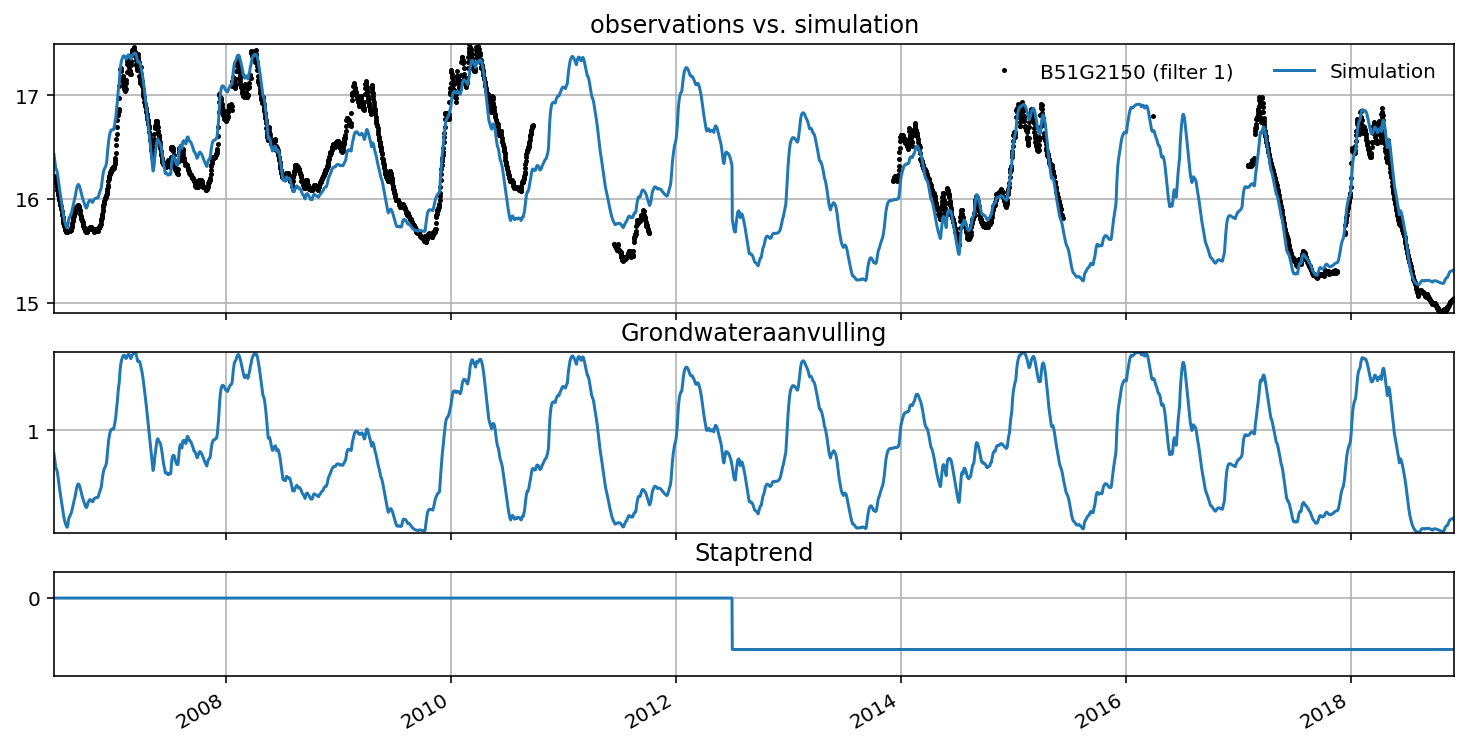

In [22]:
# Voorbeeld van model met stap respons
p = pd.read_csv("data/RD Helmond.csv", index_col=0, parse_dates=True, squeeze=True) * 1e3
e = pd.read_csv("data/EV24 Eindhoven.csv", index_col=0, parse_dates=True, squeeze=True) * 1e3
h = pd.read_csv("data/B51G2150-001.csv", index_col=0, parse_dates=True, squeeze=True)
h.name = "B51G2150 (filter 1)"
# Maak een model
ml = ps.Model(h.iloc[::1])

# Voeg stress modellen toe
sm = ps.RechargeModel(p, e, name="Grondwateraanvulling", rfunc=ps.Exponential, recharge=ps.rch.FlexModel())
step = ps.StepModel(tstart=pd.Timestamp("2012-07-01"), name="Staptrend", up=False)
ml.add_stressmodel([sm, step])

# Kalibreer het model en toon de resultaten
ml.solve(noise=False, report=False, fit_constant=fit_constant)
ml.plots.decomposition(figsize=(10,5), min_ylim_diff=1, split=False);

### Voorbeeld van een model met lineaire trend
Het gebeurt vaak dat een stijghoogte tijdreeks een opwaarste of neerwaartse trend vertoond, die niet door neerslag of verdamping verklaart kan worden. Vaak is het lastig een specifieke oorzaak aan te wijzen van een daling of stijging. Zo kan het bijvoorbeeld goed dat de vegetatietype en daardoor de verdamping en grondwateraanvulling is verandeert in de loop van de tijd. Het zal echter lastig zijn een dergelijk effect te kwantificeren en mee te nemen in het model. Vast staat echter dat zonder de trend mee te nemen in het model het lastig is de stijghoogte goed te modelleren.

---

We beschouwen hier een model voor het 1e filter in de peilbuis "B32C0609" nabij de Bilt. Als eerste stap maken we een model met neerslag en verdamping als verklarende variabelen. Dit levert het volgende model op.

[//]: # (WAT IS HIER DE INVLOED VAN DE HOOGFREQUENTE METINGEN?)

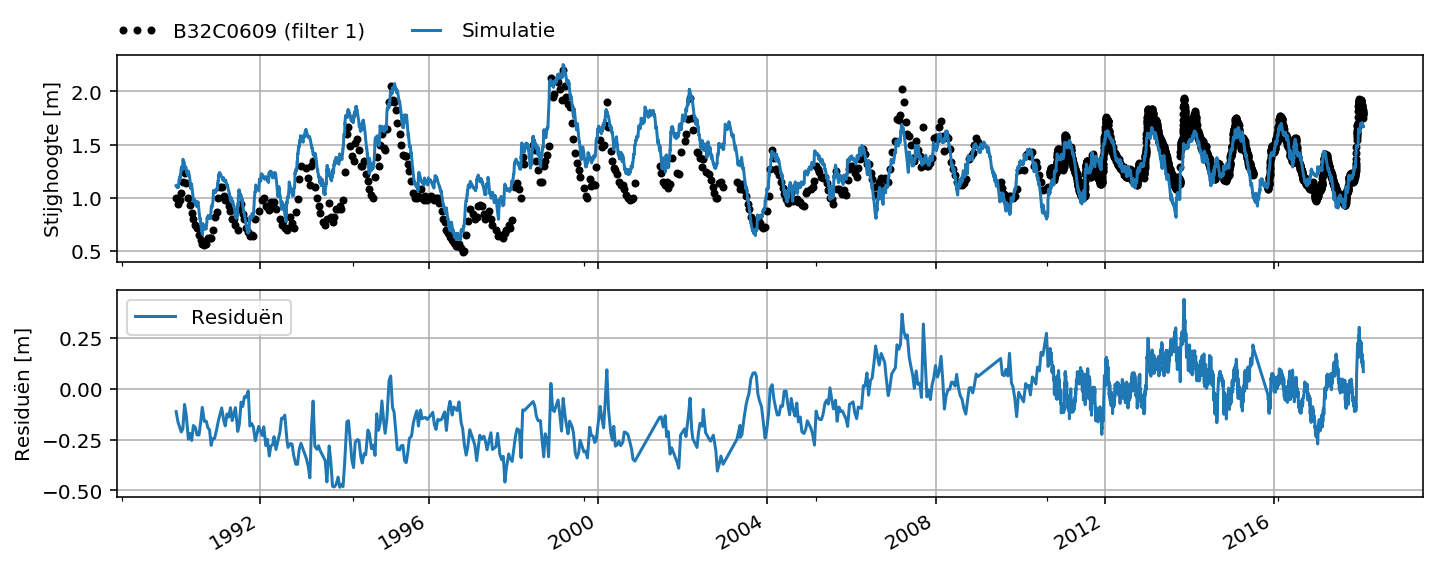

In [23]:
# Loads heads and create Pastas model
head2 = ps.read_dino("data/B32C0609001_1.csv")
evap = ps.read_knmi("data/etmgeg_260.txt", variables="EV24").series * 1e3
rain = ps.read_knmi("data/etmgeg_260.txt", variables="RH").series * 1e3
rain.name = "Neerslag"
evap.name = "Verdamping"

ml2 = ps.Model(head2, name="B32C0609 (filter 1)")

# Add a recharge model
rch = ps.rch.Linear()
rm = ps.RechargeModel(rain, evap, recharge=rch, rfunc=ps.Exponential, name="rch")
ml2.add_stressmodel(rm)

# Solve and plot the model
ml2.solve(noise=False, tmin="1990", report=False, fit_constant=fit_constant)

# Plot het model
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
ax = ml2.observations().plot(ax=ax1, linestyle=" ", marker=".", color="k");
ml2.simulate().plot(ax=ax1)
ml2.residuals().plot(ax=ax2)
ax1.grid()
ax1.set_ylabel("Stijghoogte [m]")
ax2.grid()
ax2.set_ylabel("Residuën [m]")

ax1.legend(["B32C0609 (filter 1)", "Simulatie", "Residuën"], ncol=3, bbox_to_anchor=(0.35, 1.25), frameon=False, numpoints=3)
ax2.legend(["Residuën"])
plt.tight_layout()

In de figuur hierboven is het resultaat van de modellering te weergegeven. We zien dat het model de fluctuaties in de gemeten stijghoogte in het algemeen goed kan verklaren, maar de residuën van het model laten een duidelijke opwaarste trend zien. Het model overschat de stijghoogte in het begin van de kalibratie periode en onderschat de stijghoogte aan het einde van deze periode. 

Uit de hydrologische systeemanalyse is gebleken dat er waarschijnlijk geen grondwaterontrekking in de nabijheid van de peilbuis plaatsvind. Een exacte oorzaak van de trend in de residuën kan dus niet worden aangewezen. In dit geval kan het zinvol zijn een lineaire trend aan het model toe te voegen om de simulatie van de stijghoogte te verbeteren. Het resultaat hiervan is hieronder weergegeven.

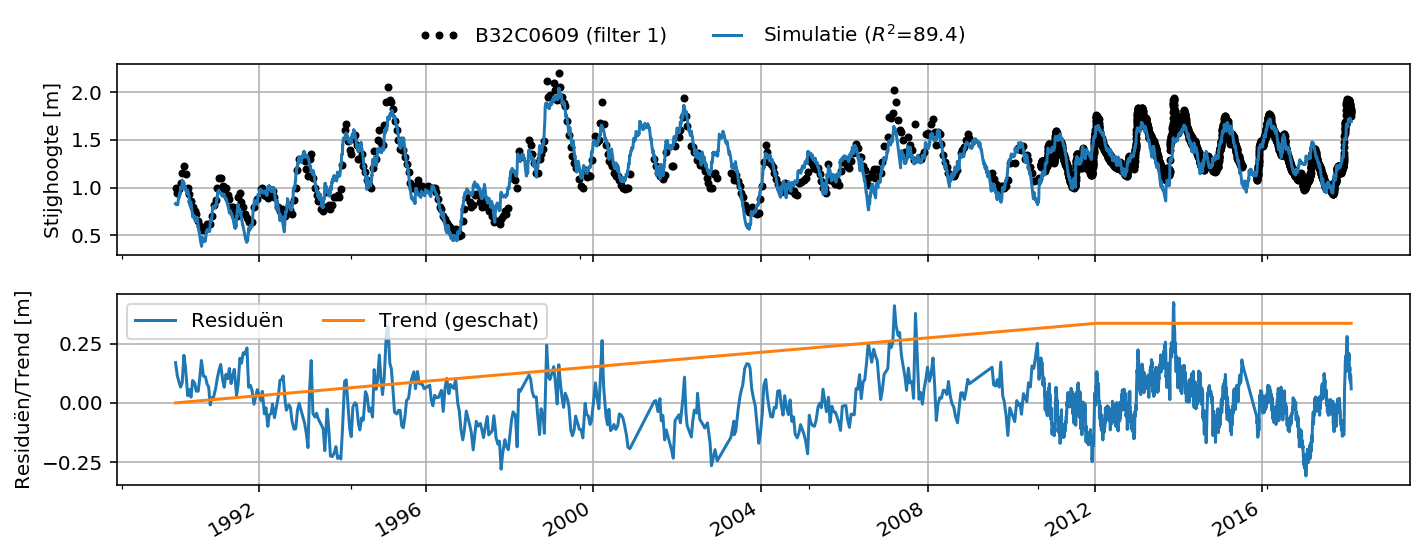

In [24]:
# Add a linear trend
tm = ps.LinearTrend(start="1990", end="2012", name="trend")
ml2.add_stressmodel(tm)

# Solve the model
ml2.solve(noise=False, tmin="1990", initial=False, report=False, fit_constant=fit_constant)

# Plot het model
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
ax = ml2.observations().plot(ax=ax1, linestyle=" ", marker=".", color="k");
ml2.simulate().plot(ax=ax1)
ml2.residuals().plot(ax=ax2)
ml2.get_contribution("trend").plot(ax=ax2)
ax1.grid()
ax1.set_ylabel("Stijghoogte [m]")
ax2.grid()
ax2.set_ylabel("Residuën/Trend [m]")
r2 = round(ml.stats.rsq()*100, 1)
ax1.legend(["B32C0609 (filter 1)", f"Simulatie ($R^2$={r2})"], ncol=2, bbox_to_anchor=(0.22, 1.0), frameon=False, numpoints=3)
ax2.legend(["Residuën", "Trend (geschat)"], ncol=2)
plt.tight_layout()

De figuur hierboven laat een duidelijke verbetering in de simulatie van de stijghoogte zien door het toevoegen van een trend. In dit voorbeeld is op basis van een visuele inspectie van de residuën ervoor gekozen de trend te stoppen in januari 2012. Dit is echter vrij arbitrair. Het is aan de modelleur een start- en einddatum te kiezen, of een trend toe te voegen voor de gehele observatieperiode. Dit hangt af van het doel van de modellering en de kennis van het systeem en de onderliggende oorzaak van de trend.

### Verandering van de responsfunctie in de loop van de tijd

Tot op dit punt in het notebook is verondersteld dat de vorm van de responsfunctie niet verandert in de tijd. Hoewel deze aanname vaak blijkt te werken, zijn er ook situaties waar dit niet het geval is. [Obergfjell et al. (2019)](#Referenties) heeft bijvoorbeeld gekeken naar de situatie waarbij de rivierbodem is uitgebaggerd, waardoor de respons van de stijghoogte op fluctuaties in de rivier waterstand verandert in de tijd. Zij hebben daarvoor een model ontwikkeld waarbij de vorm van de respons verandert over de tijd.

In [25]:
# Voorbeeld van model met pompput en zonder, significante well_A en niet

# ## Bepalen van de uiteindelijke modelstructuur

# Een belangrijke vraag is nu hoe is vast te stellen welke modelstructuur moet worden gebruikt voor de uiteindelijke analyse van het probleem. Deze vraag laat zich lastig eenduidig beantwoorden en is onderdeel van actief onderzoek. In het volgende hoofdstuk over modelbeoordeling wordt uitvoerig op deze vraag ingegaan. Hier behandelen we enkel hoe kan worden vastgesteld of een invloed moet worden meegenomen in het model.

# - hoe te bepalen welke invloeden moeten worden meegenomen?
# - hoe te bepalen welke modelstructuur beter is?


# Welke verklarende variabelen moeten worden meegenomen 

# - Toetsen van hydrologische plausibiliteit van evenwichtsrelatie (bv. well_A > 0), diagnostisch toetsen noodzakelijk
# - Lengte van de responsfunctie
# - Residuën analyse
# - hypothese toetsen

## Discussie

In dit notebook is getracht een zo compleet mogelijk overzicht te geven van de verschillende modelstructuren die in Nederland gangbaar zijn. Het is aan te raden meerdere modelstructuren te testen om de stijghoogte te modelleren, voordat een definitief model wordt gekozen. Het is over het algemeen makkelijk om modelstructuren te varieren en het kan een goede manier zijn het aantal parameters te verminderen of de fit te verbeteren. Bovendien is het natuurlijk ook mogelijk meerdere modellen te gebruiken. Een dergelijke multi-model aanpak kan een betere inschatting geven van de modelonzekerheid als gevolg de model structuur [(zie bv. Singh et al., 2010 en Ferré, 2017)](#Referenties). Waar dit voor numerieke grondwatermodellen een significante tijdsinspanning zal opleveren, is het met tijdreeksmodellen relatief makkelijk meerdere modellen te gebruiken.

Hoewel is geprobeerd hier een zo compleet mogelijk overzicht te geven van de mogelijke modelstructuren, moet worden benadrukt dat het relatief makkelijk is nieuwe modelstructuren te ontwikkelen die zijn toegespitst op specifieke situaties. In dit notebook is gebruik gemaakt van tijdreeksen met verschillende meetfrequenties. Een meetreeks met een hogere meetfrequentie kan meer informatie bevatten over processen die met een lagere meetfrequentie niet zichtbaar zijn [(zie bv. Herwijnen, 2001 en Berendrecht et al. 2003)](#Referenties). De relatie tussen de meetfrequentie en de informatie die aanwezig is in een tijdreeks is onderdeel van actief onderzoek en zal in zekere mate van belang zijn bij het bepalen het kiezen van de modelstructuur. 

## Referenties

- Knotters M. en de Gooijer, J.G. (1999) TARSO modeling of water table depths. Water Resources Research, 35:3.
- van Herwijnen, T. (2002) Tijdreeksanalyse van grondwaterpeilen: invloed van het meetinterval. Stromingen 8, Nummer 4.
- von Asmuth, J. R., Bierkens, M. F., & Maas, K. (2002). Transfer function‐noise modeling in continuous time using predefined impulse response functions. Water Resources Research, 38(12), 23-1.
- Berendrecht, W., Gehrels, H., van Geer, F., en Heemink, A., (2003) Tijdreeksanalyse kan veel beter door kleiner modelinterval. Stromingen 9, Nummer 1.
- Berendrecht, W., Gehrels, H., van Geer, F., en Heemink, A. (2004) Een niet-lineair tijdreeksmodels voor grondwaterstandsfluctuaties in gedraineerde gebieden. Stromingen 10, nummer 2.
- Berendrecht, W. L., Heemink, A. W., Van Geer, F. C., & Gehrels, J. C. (2006). A non-linear state space approach to model groundwater fluctuations. Advances in water resources, 29(7), 959-973.
- Singh, A., Mishra, S. and Ruskauff, G. (2010), Model Averaging Techniques for Quantifying Conceptual Model Uncertainty. Groundwater, 48: 701-715.
- Von Asmuth, J. R., Maas, K., Knotters, M., Bierkens, M. F., Bakker, M., Olsthoorn, T. N., Cirkel, D.G., Leunk, I., & Von Asmuth, D. C. (2012). Software for hydrogeologic time series analysis, interfacing data with physical insight. Environmental Modelling & Software, 38, 178-190.
- von Asmuth, J.,van der Schaaf, S., Grootjans, A., en Maas, K. (2012) Vennen en veentjes: (niet-)ideale systemen voor niet-lineaire tijdreeksmodellen, Stromingen 18, Nummer 2.
- Peterson, T. J., & Western, A. W. (2014). Nonlinear time‐series modeling of unconfined groundwater head. Water Resources Research, 50(10), 8330-8355.
- Ferré, T.P. (2017), Revisiting the Relationship Between Data, Models, and Decision‐Making. Groundwater, 55: 604-614.
- Obergfell, C., Bakker, M., & Maas, K. (2019). Identification and explanation of a change in the groundwater regime using time series analysis. Groundwater, 57(6), 886-894.
- Knotters, M., Baggelaar, P.K., en van der Meulen, E. (2020) Hoezo significant? Over het effect van een ingreep op de grondwaterstand. Stromingen 26, Nummer 3.
- Collenteur, R., Bakker, M., Klammler, G., & Birk, S. (2020). Estimating groundwater recharge from groundwater levels using non-linear transfer function noise models and comparison to lysimeter data. Hydrology and Earth System Sciences Discussions, 1-30.